<a href="https://colab.research.google.com/github/mfdali/PermeabilityCircularVugs/blob/main/MVP_CD_Sprint1_Monique_Dali.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP Sprint 1

## Monique Dali

### Data Science & Analytics


## 1. Definição do Problema

A base de dados utilizado neste projeto consiste em parâmetros e soluções de simulações numéricas do escoamento de fluidos em lâminas bidimensionais de duas amostras de rocha. O simulador foi implementado por Dali, Gomes e Carvalho no Laboratório de Microhidrodinâmica e Escoamento em Meios Porosos da PUC-Rio, com os objetivos de encontrar uma solução aproximada para a pressão e velocidade ao longo de um domínio com vazios e matriz porosa e calcular sua permeabilidade absoluta. Esta base é composta por imagens tomográficas de 2 amostras de carbonato com cavidades, o qual não possui solução teórica para o escoamento. Com base nessas imagens, outras foram manipuladas virtualmente para obter macroporosidades maiores. Das imagens alguns atributos foram extraídos. O dataset apresenta esses atributos obtidos da imagem, parâmetros de construção do estudo e a permeabilidade absoluta encontrada pela simulação.
Para mais detalhes sobre o estudo que gerou este dataset, o artigo encontra-se disponível em: https://www.researchgate.net/publication/337746813_Equivalent_permeability_in_vuggy_porous_media_using_Brinkman's_model

**Informações sobre os atributos:**
1. **Image_file, Id1, Id2, Slice** - Nome e identificadores da imagem 
2. **Sample** - Amostra 5 ou 8
3. **Threshold** - Técnica de manipulação da imagem utilizada, onde 1 representa a imagem binarizada sem manipulações das cavidades. 
4. **%Area** - Macroporosidade que representa o percentual que as cavidades ocupam no domínio (%) 
5. **K(m2),Keq(m2)** - Permeabilidade da matriz porosa e permeabilidade equivalente (m²) 
6. **Delta P(Pa)** - Diferencial de pressão imposto na simulação (Pa)  
7. **Count** - Quantidade de cavidades 
8. **Total Area** - Area das cavidade em pixels
9. **Average Size** - Média da cavidade
10. **Perimeter** - Perimetro médio das cavidades
11. **Knorm** - Permeabilidade equivalente dividido pela permeabilidade da matriz porosa. Representa o incremento de permabilidade devido a presença das cavidades.
12. **Direction** - Direção na imagem em que o escoamento foi simulado.


**Exemplo de imagem pertencente a base de dados**

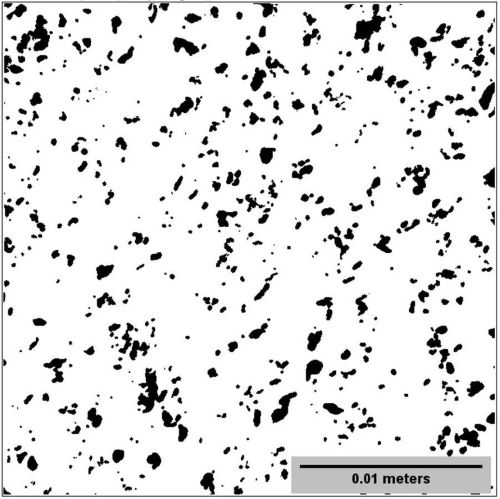

## Ferramentas

Seção que contém as bibliotecas e funções utilizadas ao longo do notebook

### Python libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms # missing treatment
from matplotlib import cm
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR 
from lightgbm import LGBMRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import Ridge 
from sklearn.linear_model import Lasso 
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.inspection import permutation_importance
import math

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Classes and functions

In [58]:
# Classes and functions

class LoadData:

    def load_file(self, url: str):
        """ Load dataset """
        return pd.read_csv(url, delimiter=',', header=0)


class PreProcess:

    def pre_processing(self, dataset, percentual_test, seed=7):
        """ Database pre-processing """
        # Clean data. Find and ignore outliers 
        
        # Feature selection

        # Split dataframe in train and test data
        X_train, X_test, Y_train, Y_test = self.__prepare_holdout(dataset,
                                                                  percentual_test,
                                                                  seed)
        
        return (X_train, X_test, Y_train, Y_test)

    def standardization(self, train_var, test_var, seed=7):
      # standardization - rescale data to mean of 0
      sc = StandardScaler()
      v_train = sc.fit_transform(train_var)
      v_test = sc.transform(test_var)

      return (v_train, v_test)

    def normalization(self, train_var, test_var, seed=7):
      # Normalization - range between 0 and 1
      sc = MinMaxScaler()
      v_train = sc.fit_transform(train_var)
      v_test = sc.transform(test_var)

      return (v_train, v_test)

    def __prepare_holdout(self, dataset, percentual_test, seed):
        """ Split dataframe in train and test set   """
        
        df = dataset.values
        X = df[:, 0:-1] # Attributes
        Y = df[:, -1] # Target in the last column
        return train_test_split(X, Y, test_size=percentual_test, random_state=seed, shuffle=True)

    def clean_data(self, dataset):
      # Copy dataset
      cleaned_dataset = dataset

      # transform zeros into NaN values
      cleaned_dataset.replace(0, np.nan, inplace=True)

      # Clean data
      cleaned_dataset = cleaned_dataset[~cleaned_dataset.isnull().any(axis=1)]

      return cleaned_dataset

    def ignore_values(self, dataset, column_header, condition, cut_value):

      if condition is 'bigger':
        ignore_dataset = dataset[dataset[column_header]>=cut_value]
      if condition is 'less':
        ignore_dataset = dataset[dataset[column_header]<=cut_value]
      return ignore_dataset


class Model:

    def train_SVM(self, X_train, Y_train):
        """ Create and train SVM model """
        reg_model = SVR()
        reg_model.fit(X_train, Y_train)
        return reg_model

    def generic_train(self, reg_model, X_train, Y_train):
        """ Create and train SVM model """
        reg_model.fit(X_train, Y_train)
        return reg_model

    def train_models(self, models, X_train, Y_train, kfold):  
      
      # List to hold name and result of each model
      results = []
      names = []
      print("Model:\t MAE_mean\t (MAE_std)\n")
      # Evaluate model
      for name, model in models:
        cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='neg_mean_absolute_error')
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, abs(cv_results.mean()), cv_results.std()) # mean and standard deviation
        print(msg)

      return (names,results)

class Evaluate:

    def eval_accuracy(self, reg_model, X_test, Y_test):
        """ Predicts and evaluate the model """
        predictions = reg_model.predict(X_test)
        mae = mean_absolute_error(Y_test, predictions)
        mse = mean_squared_error(Y_test, predictions)
        rmse = np.sqrt(abs(mse))
        print("MAE:%0.2f\t MSE:%0.2f\t RMSE:%0.2f\n" % (mae,mse,rmse))
        
        return predictions
    
    def singlerow_boxplot(self, dataset):
      ''' Create a single row boxplot for every numeric columns on dataframe '''
      # Get columns with type of data numeric
      values_headers = dataset._get_numeric_data().columns.tolist()
      df = dataset[values_headers]

      #Creating subplot of each column with its own scale
      red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

      fig, axs = plt.subplots(1, len(df.columns), figsize=(20,10))

      for i, ax in enumerate(axs.flat):
          ax.boxplot(df.iloc[:,i], flierprops=red_circle)
          ax.set_title(df.columns[i], fontsize=20, fontweight='bold')
          ax.tick_params(axis='y', labelsize=14)
          
      plt.tight_layout()
      plt.show()



In [59]:
# Calling Classes
load = LoadData()
pre_process = PreProcess()
select_model = Model()
evaluation = Evaluate()

## 2. Carga de Dados

A partir do github carregamos um arquivo .csv que contém cabeçalhos através do pacote Pandas.

In [5]:
# Parameters
url_dataframe = ('https://raw.githubusercontent.com/mfdali/PermeabilityCircularVugs/main/database/rock-sample-simulation-data.csv') # link from GitHub
percentual_test = 0.2 # Percentual of occurencies reserved to test the model

# Load dataframe
dataset = load.load_file(url_dataframe)

# Show few lines of the dataframe
dataset.head()

Image_file          Id1  Id2  Sample  Threshold  Slice     %Area  \
0  am5_c1_final-0150  am5_c1_s150  150       5          1    150  11.85522   
1  am5_c1_final-0151  am5_c1_s151  151       5          1    151  12.04248   
2  am5_c1_final-0152  am5_c1_s152  152       5          1    152  10.85474   
3  am5_c1_final-0153  am5_c1_s153  153       5          1    153   9.97021   
4  am5_c1_final-0154  am5_c1_s154  154       5          1    154   8.76489   

          K(m2)       Keq(m2)  Delta P(Pa)  Count  Total Area  Average Size  \
0  1.000000e-15  1.313430e-15      6894.76    479       48559     101.37578   
1  1.000000e-15  1.313130e-15      6894.76    496       49326      99.44758   
2  1.000000e-15  1.256460e-15      6894.76    496       44461      89.63911   
3  1.000000e-15  1.233960e-15      6894.76    468       40838      87.26068   
4  1.000000e-15  1.194400e-15      6894.76    478       35901      75.10669   

   Perimeter    Knorm Direction  
0   36.33522  1.31343         X  
1   35.89300  1.31313         X  
2   33.38860  1.25646         X  
3   32.84939  1.23396         X  
4   29.62648  1.19440         X

In [6]:
# Hold headers
headers_list = dataset.columns.values.tolist()
headers_list

['Image_file',
 'Id1',
 'Id2',
 'Sample',
 'Threshold',
 'Slice',
 '%Area',
 'K(m2)',
 'Keq(m2)',
 'Delta P(Pa)',
 'Count',
 'Total Area',
 'Average Size',
 'Perimeter',
 'Knorm',
 'Direction']

In [ ]:
'''# Another way to get the column names
col = list(dataset.columns)'''

## 3. Análise de Dados

### 3.1. Estatísticas Descritivas

Vamos iniciar examinando as dimensões do dataset, suas informações e alguns exemplos de linhas. Inicialmente a base contém 26.256 figuras com 16 atributos relacionados a estas imagens.

In [7]:
# dataset dimension
print(dataset.shape)

(26256, 16)


In [8]:
# info of dataset
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26256 entries, 0 to 26255
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Image_file    26256 non-null  object 
 1   Id1           26256 non-null  object 
 2   Id2           26256 non-null  int64  
 3   Sample        26256 non-null  int64  
 4   Threshold     26256 non-null  int64  
 5   Slice         26256 non-null  int64  
 6   %Area         26256 non-null  float64
 7   K(m2)         25736 non-null  float64
 8   Keq(m2)       25304 non-null  float64
 9   Delta P(Pa)   26256 non-null  float64
 10  Count         26256 non-null  int64  
 11  Total Area    26256 non-null  int64  
 12  Average Size  26256 non-null  float64
 13  Perimeter     26256 non-null  float64
 14  Knorm         24082 non-null  float64
 15  Direction     26256 non-null  object 
dtypes: float64(7), int64(6), object(3)
memory usage: 3.2+ MB
None


Considerando que o arquivo contem 26.256 linhas de informação, já é possível identificar que algumas linhas de dados não possuem informações para alguns atributos, como K(m2), Keq(m2) e Knorm.

Como pode ser necessário realizar conversões no tipo de dados, verifica-se novamente o tipo dos atributos do dataset.

In [9]:
# Data type of each column
dataset.dtypes

Image_file       object
Id1              object
Id2               int64
Sample            int64
Threshold         int64
Slice             int64
%Area           float64
K(m2)           float64
Keq(m2)         float64
Delta P(Pa)     float64
Count             int64
Total Area        int64
Average Size    float64
Perimeter       float64
Knorm           float64
Direction        object
dtype: object

A princípio não será necessário realizar conversões. Porém, o dataset apresenta muitas colunas com identificadores como 'Image_file', 'Id1', 'Id2', 'Sample', 'Threshold' e 'Slice'. Colunas com informações constantes para todo o conjunto como 'K(m2)' e 'Delta P(Pa)'. Estes atributos não serão utilizados na estatística descritiva.
 

In [10]:
# Generate descriptive statistics
dataset.describe()

Id2        Sample     Threshold         Slice         %Area  \
count  26256.000000  26256.000000  26256.000000  26256.000000  26256.000000   
mean     970.000000      6.500000      2.500000    970.000000     20.546175   
std      473.724829      1.500029      1.118055    473.724829     17.172582   
min      150.000000      5.000000      1.000000    150.000000      1.544430   
25%      560.000000      5.000000      1.750000    560.000000      7.963990   
50%      970.000000      6.500000      2.500000    970.000000     14.466675   
75%     1380.000000      8.000000      3.250000   1380.000000     30.721072   
max     1790.000000      8.000000      4.000000   1790.000000     99.375980   

              K(m2)       Keq(m2)   Delta P(Pa)         Count     Total Area  \
count  2.573600e+04  2.530400e+04  2.625600e+04  26256.000000   26256.000000   
mean   9.525179e-16  6.351285e-15  6.894760e+03    204.416362   84157.131399   
std    2.126719e-16  1.543846e-14  2.728536e-12    111.138620   70338.894938   
min    0.000000e+00 -5.319260e-14  6.894760e+03      1.000000    6326.000000   
25%    1.000000e-15  1.103072e-15  6.894760e+03    107.000000   32620.500000   
50%    1.000000e-15  1.416220e-15  6.894760e+03    164.000000   59255.500000   
75%    1.000000e-15  2.385188e-15  6.894760e+03    316.000000  125833.500000   
max    1.000000e-15  2.131650e-13  6.894760e+03    557.000000  407044.000000   

        Average Size     Perimeter         Knorm  
count   26256.000000  26256.000000  24082.000000  
mean      912.846978     82.626791      6.673570  
std      8000.290636     70.901177     15.757224  
min        38.060090     20.506060    -53.192600  
25%       119.053458     40.503810      1.138948  
50%       384.685790     73.595160      1.439030  
75%       849.222422    108.459450      2.781420  
max    407044.000000   2549.656740    213.165000

Na cópia do dataset, 3 atributos para agrupamento foram mantidos 'Sample', 'Threshold' e 'Direction'. Se juntam a estes, os atributos relacionados à imagem e a resposta da simulação numérica 'Knorm'.

In [16]:
# Selected columns
headers_values = ['Id1', 'Sample', 'Threshold', '%Area', 'Keq(m2)', 'Count', 'Total Area', 'Average Size', 'Perimeter', 'Knorm', 'Direction']

# Load the selected columns of the dataframe
nolabel_dataset = dataset[headers_values]

# Show few lines of the dataframe
nolabel_dataset.head()

Id1  Sample  Threshold     %Area       Keq(m2)  Count  Total Area  \
0  am5_c1_s150       5          1  11.85522  1.313430e-15    479       48559   
1  am5_c1_s151       5          1  12.04248  1.313130e-15    496       49326   
2  am5_c1_s152       5          1  10.85474  1.256460e-15    496       44461   
3  am5_c1_s153       5          1   9.97021  1.233960e-15    468       40838   
4  am5_c1_s154       5          1   8.76489  1.194400e-15    478       35901   

   Average Size  Perimeter    Knorm Direction  
0     101.37578   36.33522  1.31343         X  
1      99.44758   35.89300  1.31313         X  
2      89.63911   33.38860  1.25646         X  
3      87.26068   32.84939  1.23396         X  
4      75.10669   29.62648  1.19440         X

In [ ]:
'''# Another way
nolabel_dataset = dataset.drop(['Image_file','Id2','Slice','K(m2)','Delta P(Pa)'], axis=1)#, inplace=True)

# Show few lines of the dataframe
nolabel_dataset.head()'''

"# Another way\nnolabel_dataset = dataset.drop(['Image_file','Id2','Slice','K(m2)','Delta P(Pa)'], axis=1)#, inplace=True)\n\n# Show few lines of the dataframe\nnolabel_dataset.head()"

In [17]:
# Show the dimension of the dataset
print("Shape: " + str(nolabel_dataset.shape))
# Info of dataset
print("\nDataset without label info:\n")
print(nolabel_dataset.info())

Shape: (26256, 11)

Dataset without label info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26256 entries, 0 to 26255
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id1           26256 non-null  object 
 1   Sample        26256 non-null  int64  
 2   Threshold     26256 non-null  int64  
 3   %Area         26256 non-null  float64
 4   Keq(m2)       25304 non-null  float64
 5   Count         26256 non-null  int64  
 6   Total Area    26256 non-null  int64  
 7   Average Size  26256 non-null  float64
 8   Perimeter     26256 non-null  float64
 9   Knorm         24082 non-null  float64
 10  Direction     26256 non-null  object 
dtypes: float64(5), int64(4), object(2)
memory usage: 2.2+ MB
None


Conversão das colunas e seu tipos de dados após a transformação em variáveis categóricas.

In [18]:
# convert Id1 to object 
nolabel_dataset['Id1'] = nolabel_dataset['Id1'].astype('object')

# convert selected columns of a DataFrame to category as there are lots of repetition
nolabel_dataset['Sample'] = nolabel_dataset['Sample'].astype('category')
nolabel_dataset['Threshold'] = nolabel_dataset['Threshold'].astype('category')
nolabel_dataset['Direction'] = nolabel_dataset['Direction'].astype('category')

In [19]:
# Data type of each column
nolabel_dataset.dtypes

Id1               object
Sample          category
Threshold       category
%Area            float64
Keq(m2)          float64
Count              int64
Total Area         int64
Average Size     float64
Perimeter        float64
Knorm            float64
Direction       category
dtype: object

Estatística descritiva para a cópia do dataframe. Por padrão a função exclui as variáveis categóricas e valores vazios.

In [22]:
# Generate descriptive statistics (central tendency, dispersion and shape)
nolabel_dataset.describe()

%Area       Keq(m2)         Count     Total Area   Average Size  \
count  26256.000000  2.530400e+04  26256.000000   26256.000000   26256.000000   
mean      20.546175  6.351285e-15    204.416362   84157.131399     912.846978   
std       17.172582  1.543846e-14    111.138620   70338.894938    8000.290636   
min        1.544430 -5.319260e-14      1.000000    6326.000000      38.060090   
25%        7.963990  1.103072e-15    107.000000   32620.500000     119.053458   
50%       14.466675  1.416220e-15    164.000000   59255.500000     384.685790   
75%       30.721072  2.385188e-15    316.000000  125833.500000     849.222422   
max       99.375980  2.131650e-13    557.000000  407044.000000  407044.000000   

          Perimeter         Knorm  
count  26256.000000  24082.000000  
mean      82.626791      6.673570  
std       70.901177     15.757224  
min       20.506060    -53.192600  
25%       40.503810      1.138948  
50%       73.595160      1.439030  
75%      108.459450      2.781420  
max     2549.656740    213.165000

Estatística descritiva para as variáveis categóricas do dataframe. A linha unique mostra que são 2 amostras de rocha, 4 técnicas de manipulação de imagens e 2 direções de escoamento nas lâminas.

In [23]:
# Generate descriptive statistics for pandas categorical columns
nolabel_dataset.describe(include=['category'])

Sample  Threshold Direction
count    26256      26256     26256
unique       2          4         2
top          5          1         X
freq     13128       6564     13128

Ao verificar a linha freq na estatística descritiva, que indica a quantidade de dados por classe podemos ver que elas estão balanceadas. Como não se trata de um problema de classificação, acessaremos também a dispersão dos dados. Vamos guardar esta informação, pois possivelmente precisaremos realizar algum tipo de tratamento nas próximas etapas.

### 3.2. Visualizações Unimodais

Com um histograma para cada atributo do dataset; e o máximo e mínimo da descritiva, veremos que os atributos Average Size, Perimeter e Knorm possuem poucas ocorrência de valores afastados dos de maior incidência. As colunas %Area e Total Area seguem uma distribuição exponencial.

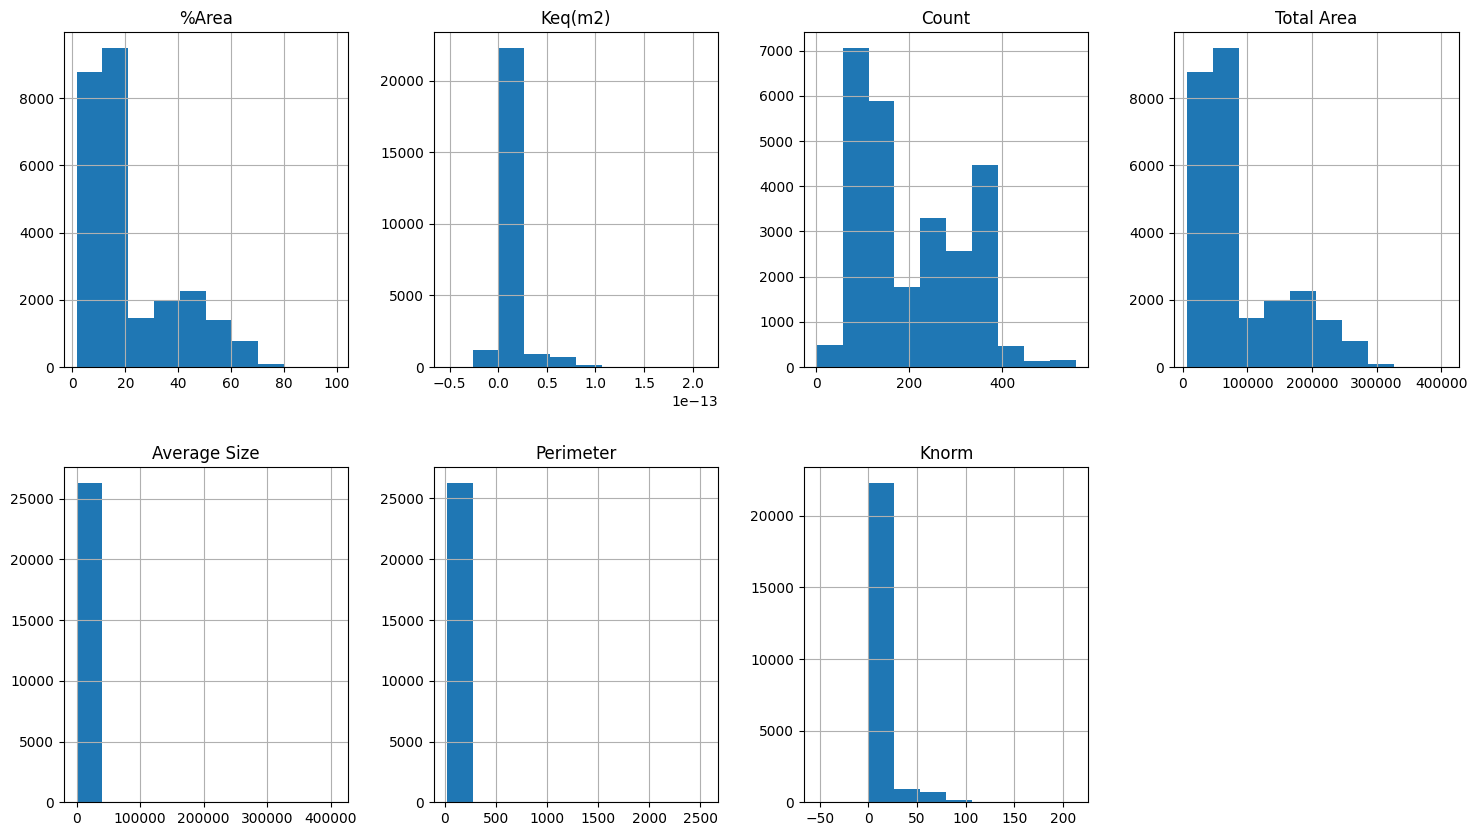

In [24]:
# Histogram
nolabel_dataset.hist(figsize = (18,10), layout = (2,4))
plt.show()

Para verificar as poucas colunas visíveis no histogrma para os atributos Keq(m2), Average Size, Perimeter e Knorm, vamos agora trabalhar com boxplots. 

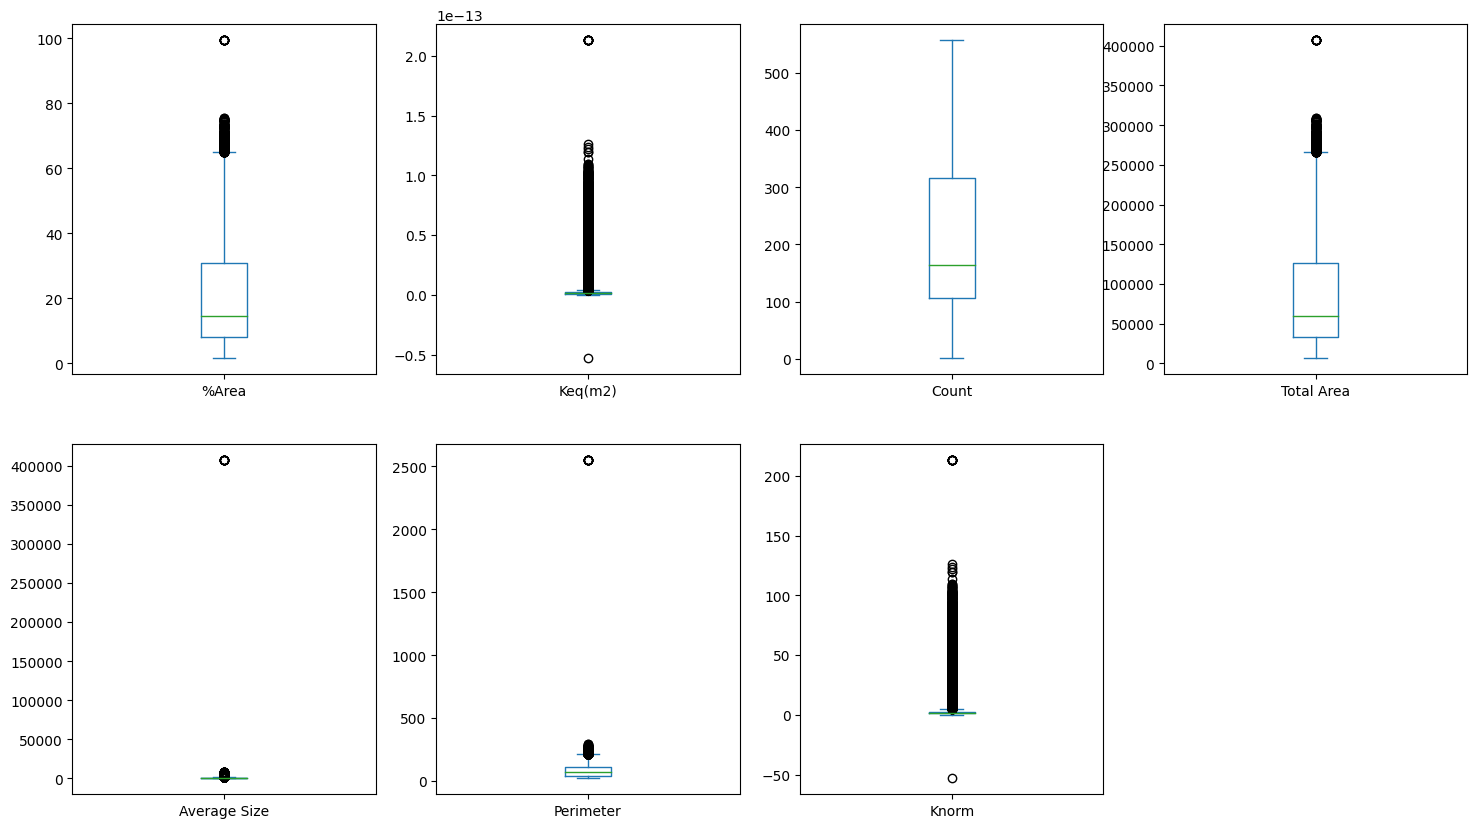

In [26]:
# Boxplots
nolabel_dataset.plot(kind = 'box', subplots = True, layout = (2,4), sharex = False, sharey = False, figsize = (18,10))
plt.show()

Nos gráficos bloxplot, podemos verificar que a dispersão dos atributos do dataset é bem diferente. Há possíveis outliers e as variáveis Keq(m2) e Knorm possuem muitas ocorrências distante da média.

array([<Axes: title={'center': '%Area'}, xlabel='Threshold'>,
       <Axes: title={'center': 'Knorm'}, xlabel='Threshold'>],
      dtype=object)

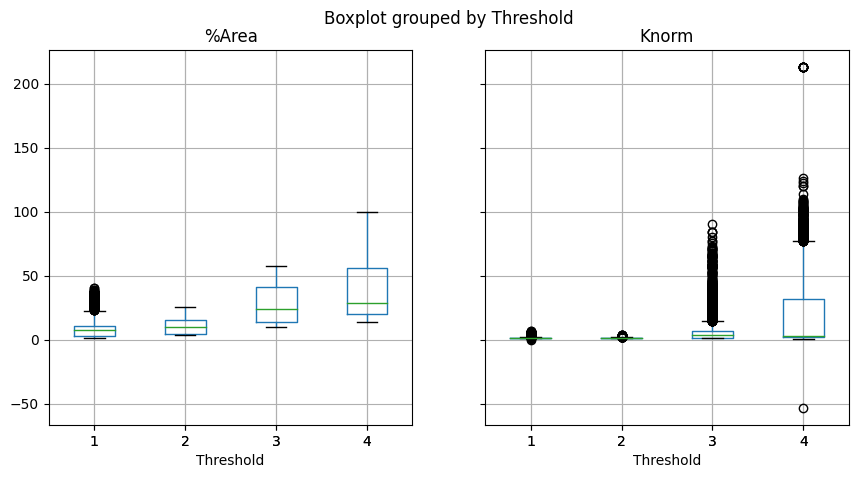

In [27]:
# Boxplots of two variables distributions grouped by the values of a third variable
nolabel_dataset.boxplot(column=['%Area','Knorm'], by='Threshold', layout = (1,2), figsize = (10,5))

Vamos analisar mais profundamente 2 colunas de dados, doq ual se espera uma relação de dependência maior. um Um meio poroso possuindo uma área maior de vazios tende a ter velocidade de escoamento mais alta devido a facilidade que o fluido tem de transitar. 

No boxplot agrupado pela variável Threshold, verifica-se que o %Area cresce com a técnica de manipulação empregada. Knorm apresenta uma relação próxima de crescimento com o %Area, mas uma grande dispersão dos dados mesmo dentro de cada classe.

### 3.3. Visualizações Multimodais


As correlações entre as variáveis foram acessados através da matriz de correlação e o gráfico de dispersão pareado. O gráfico a seguir indica que algumas variáveis estão relacionadas. No caso de %Area e Total Area a matriz a correlação é igual a 1 pois elas indicam o mesmo atributo extraído da imagem só que em unidades diferentes. No caso %Area em percentual e Total Area em pixels.Será importante utilizar apenas uma entre estas duas informações em uma regressão. Este também é o caso de Keq(m2) que representa a divisão de 2 colunas, sendo uma delas constante.

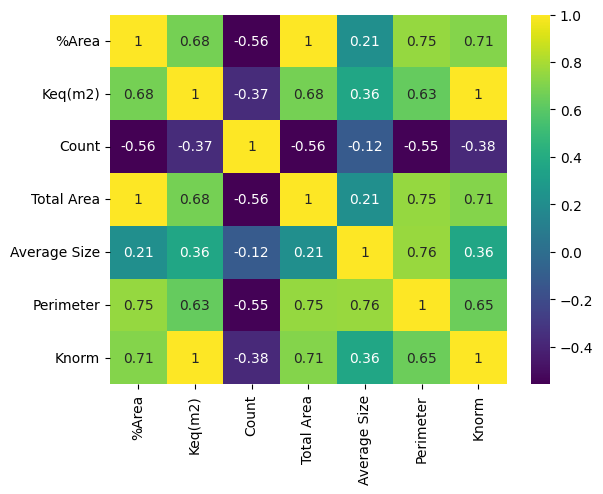

In [28]:
# Matriz de Correlação com Matplotlib Seaborn
sns.heatmap(nolabel_dataset.corr(), annot=True, cmap='viridis');

Vamos exibir um gráfico para cada par de atributos dos dataset usando o Seaborn. Analisando o gráfico de dispersão observa-se melhor o tipo de relacionamento entre duas variáveis quaisquer relacionadas na matriz de correlação.

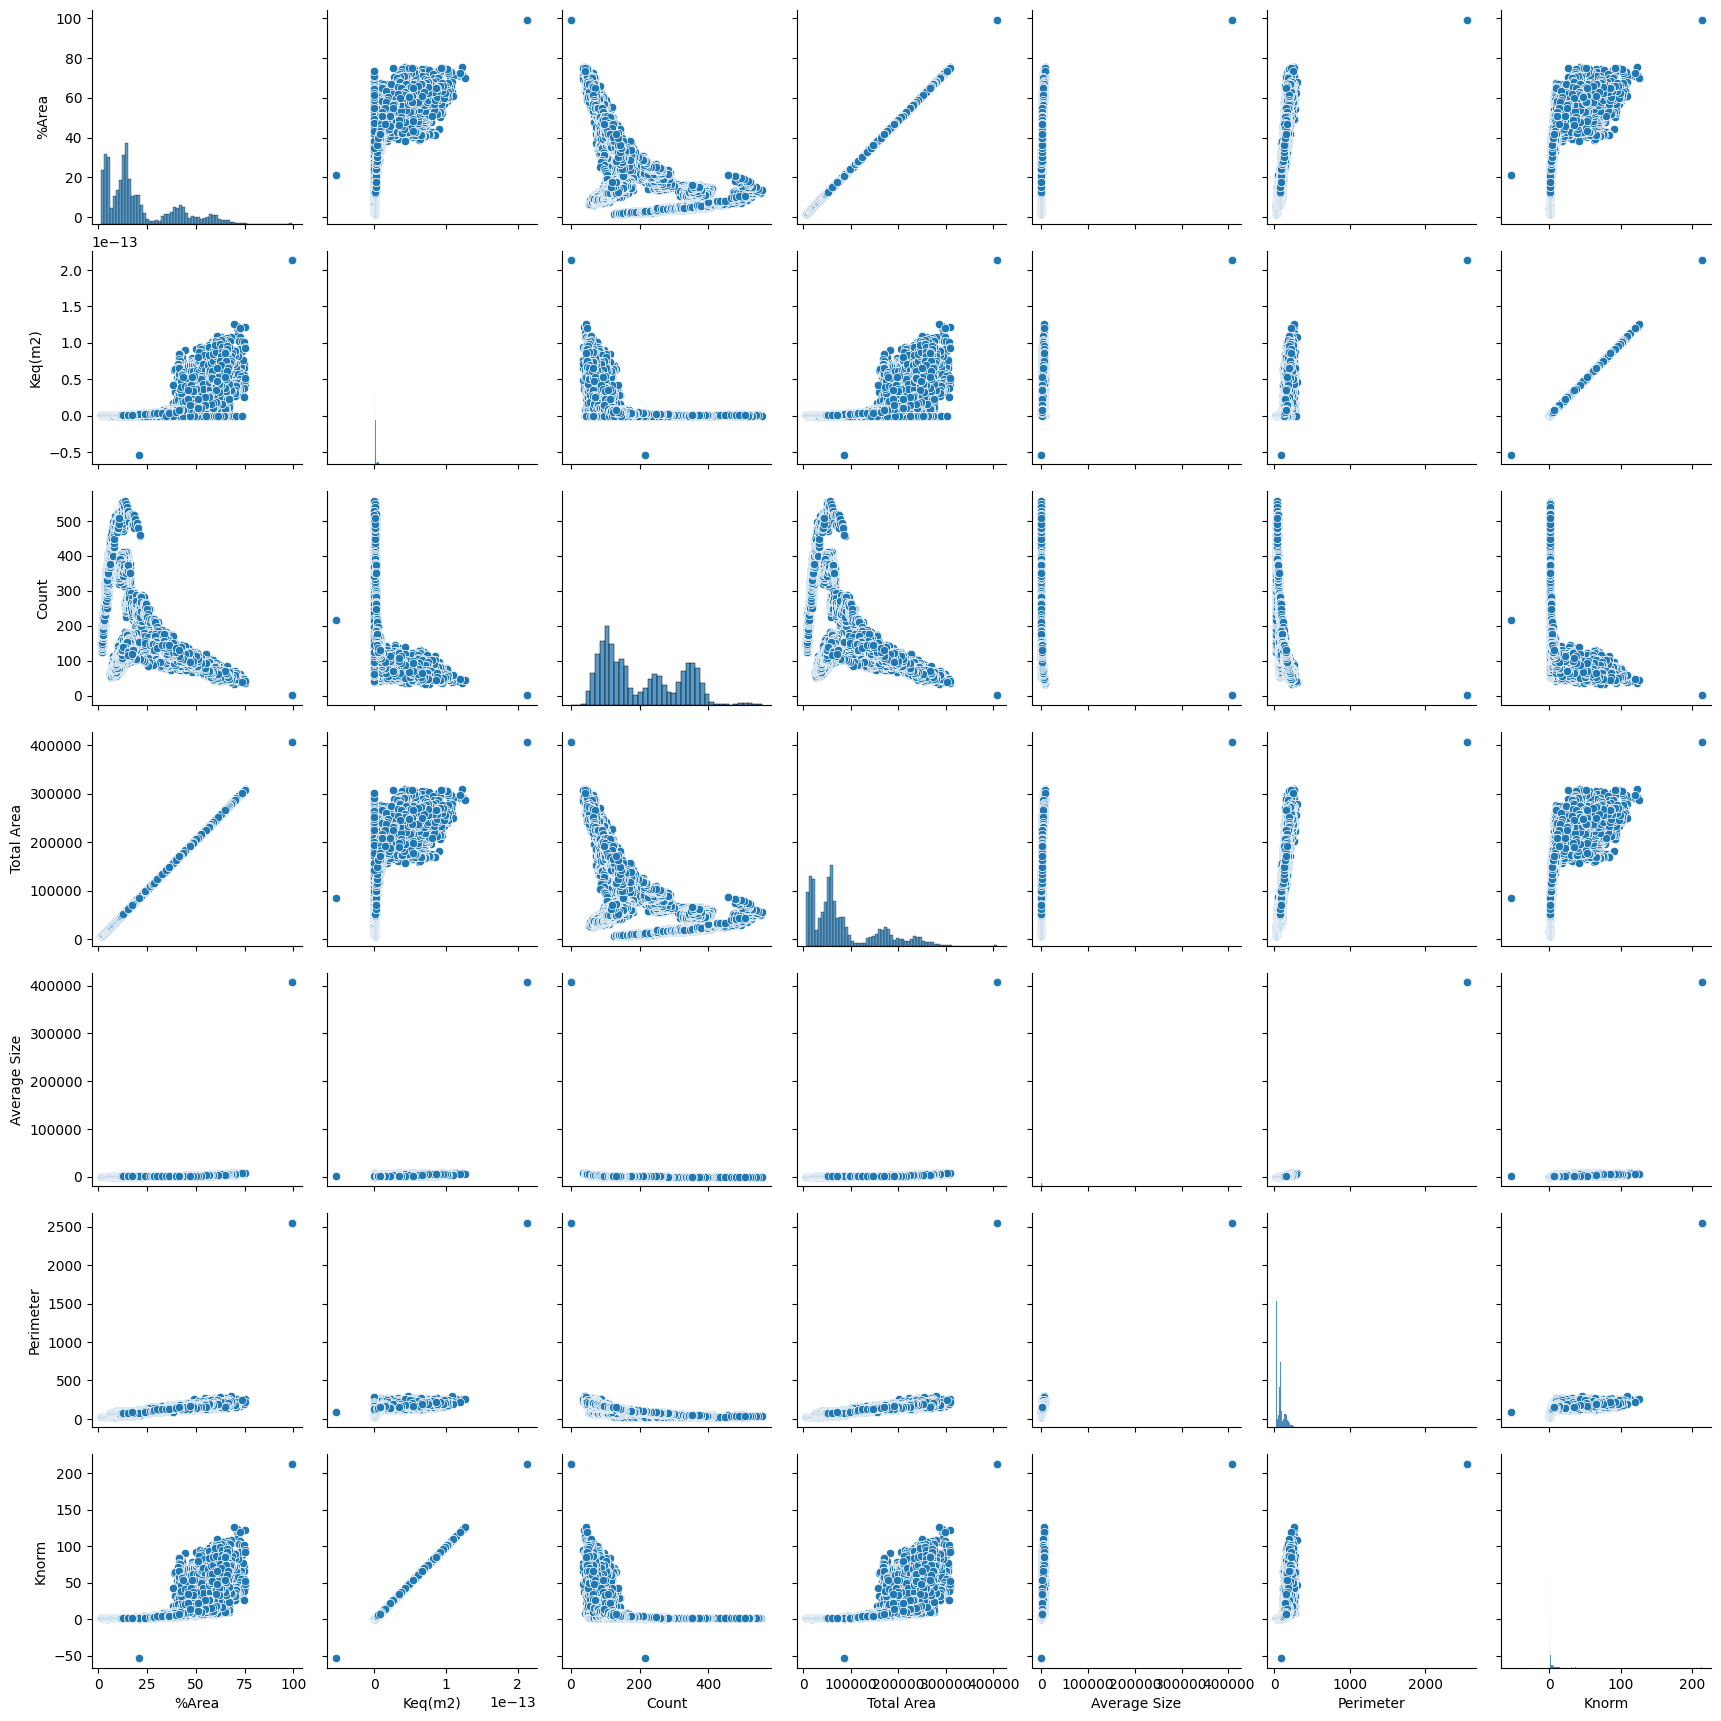

In [29]:
# Seaborn plot for pairwise relationship
sns.pairplot(nolabel_dataset, palette = "viridis_r", height = 2.5)

Analisando o gráfico acima poucas informações puderam ser extraídas. Observa-se a relação direta entre Keq(m2)-Knorm e %Area-Total Area. Apenas um de cada par deverá ser mantido no modelo. Para os demais, não foi possível identificar se há relação exponencial ou polinomial entre dois atributos da base.

## 4. Pré-Processamento de dados

Nesta etapa, vamos realizar operações de preparação de dados, como tratamento de valores faltantes, limpeza de dados e seleção de características.

### 4.1. Tratamento de Missings e Limpeza


Sabemos que o dataset apresenta missings, nesta etapa vamos fazer este tratamento e criar uma nova versão do dataset.

In [30]:
# verify nulls occurencies on dataset
nolabel_dataset.isnull().sum()

Id1                0
Sample             0
Threshold          0
%Area              0
Keq(m2)          952
Count              0
Total Area         0
Average Size       0
Perimeter          0
Knorm           2174
Direction          0
dtype: int64

<Axes: >

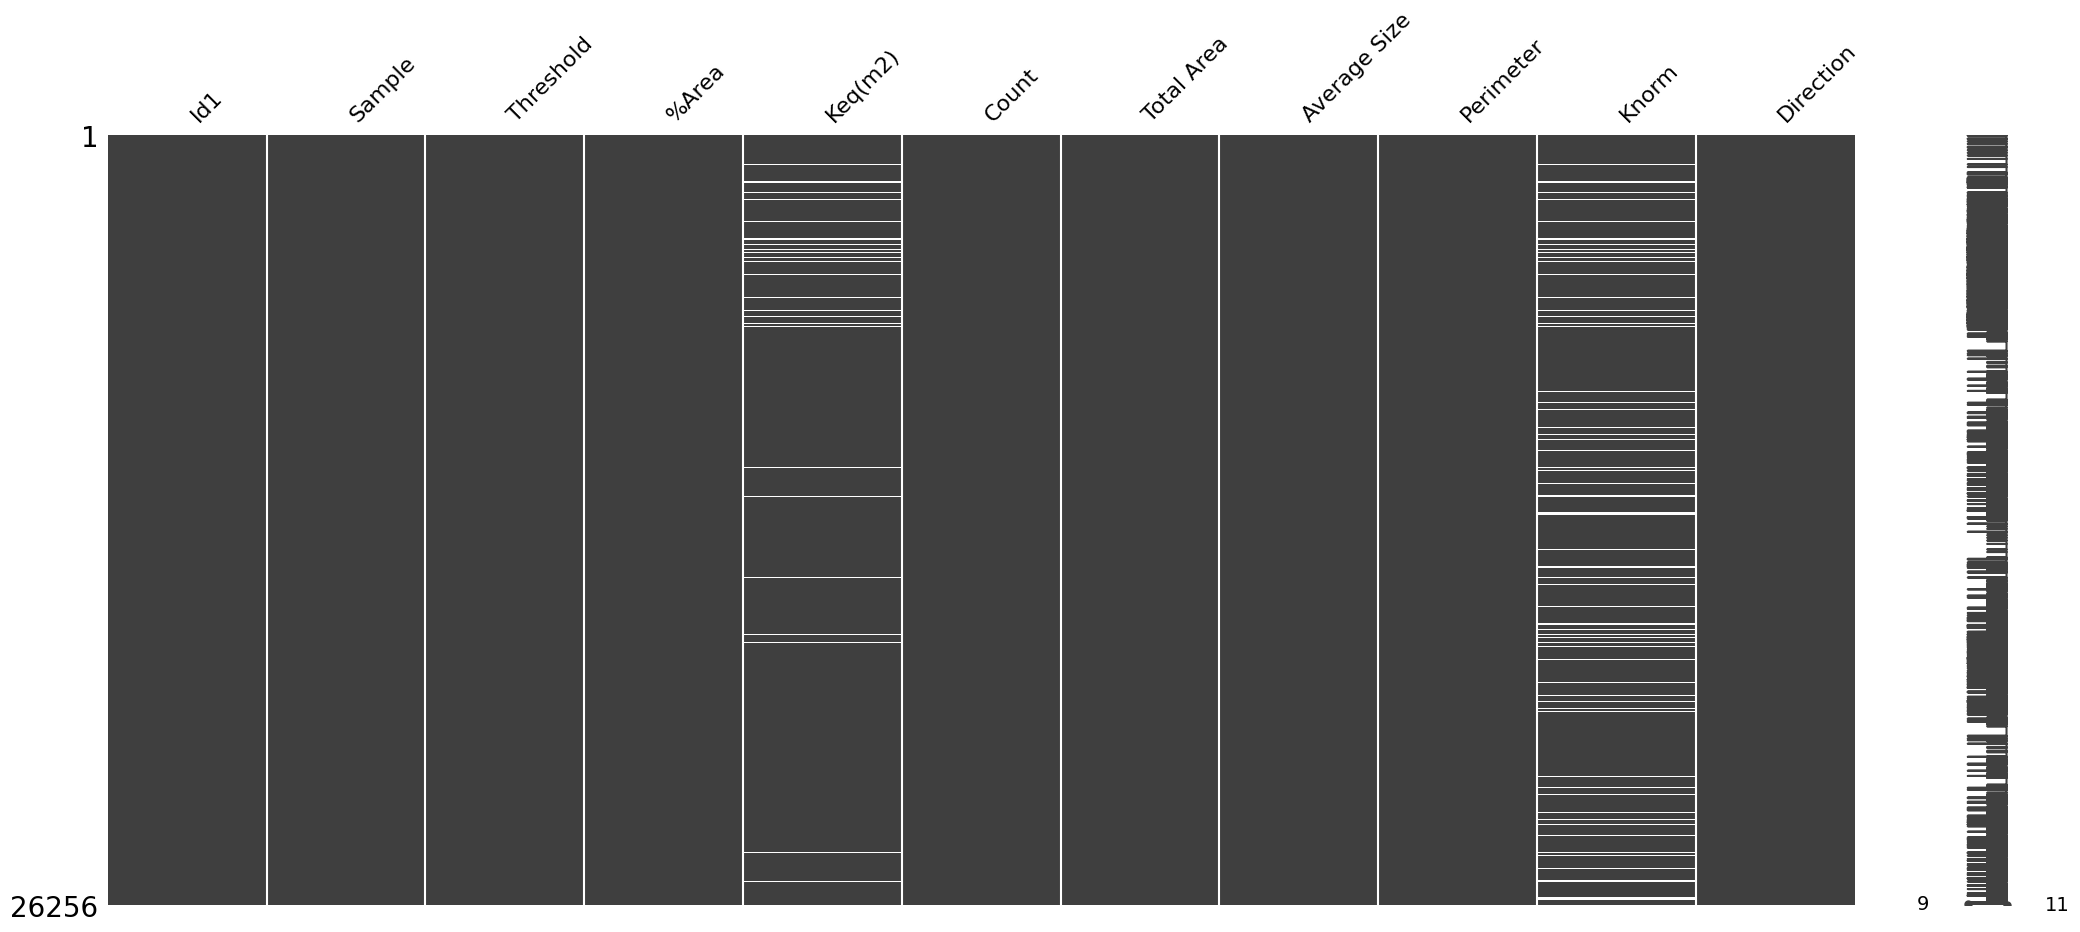

In [31]:
# Matrix plot shows absent data displayed in white
ms.matrix(nolabel_dataset)

Vamos criar uma nova cópia da base de dados sem zeros e valores NaN

<Axes: >

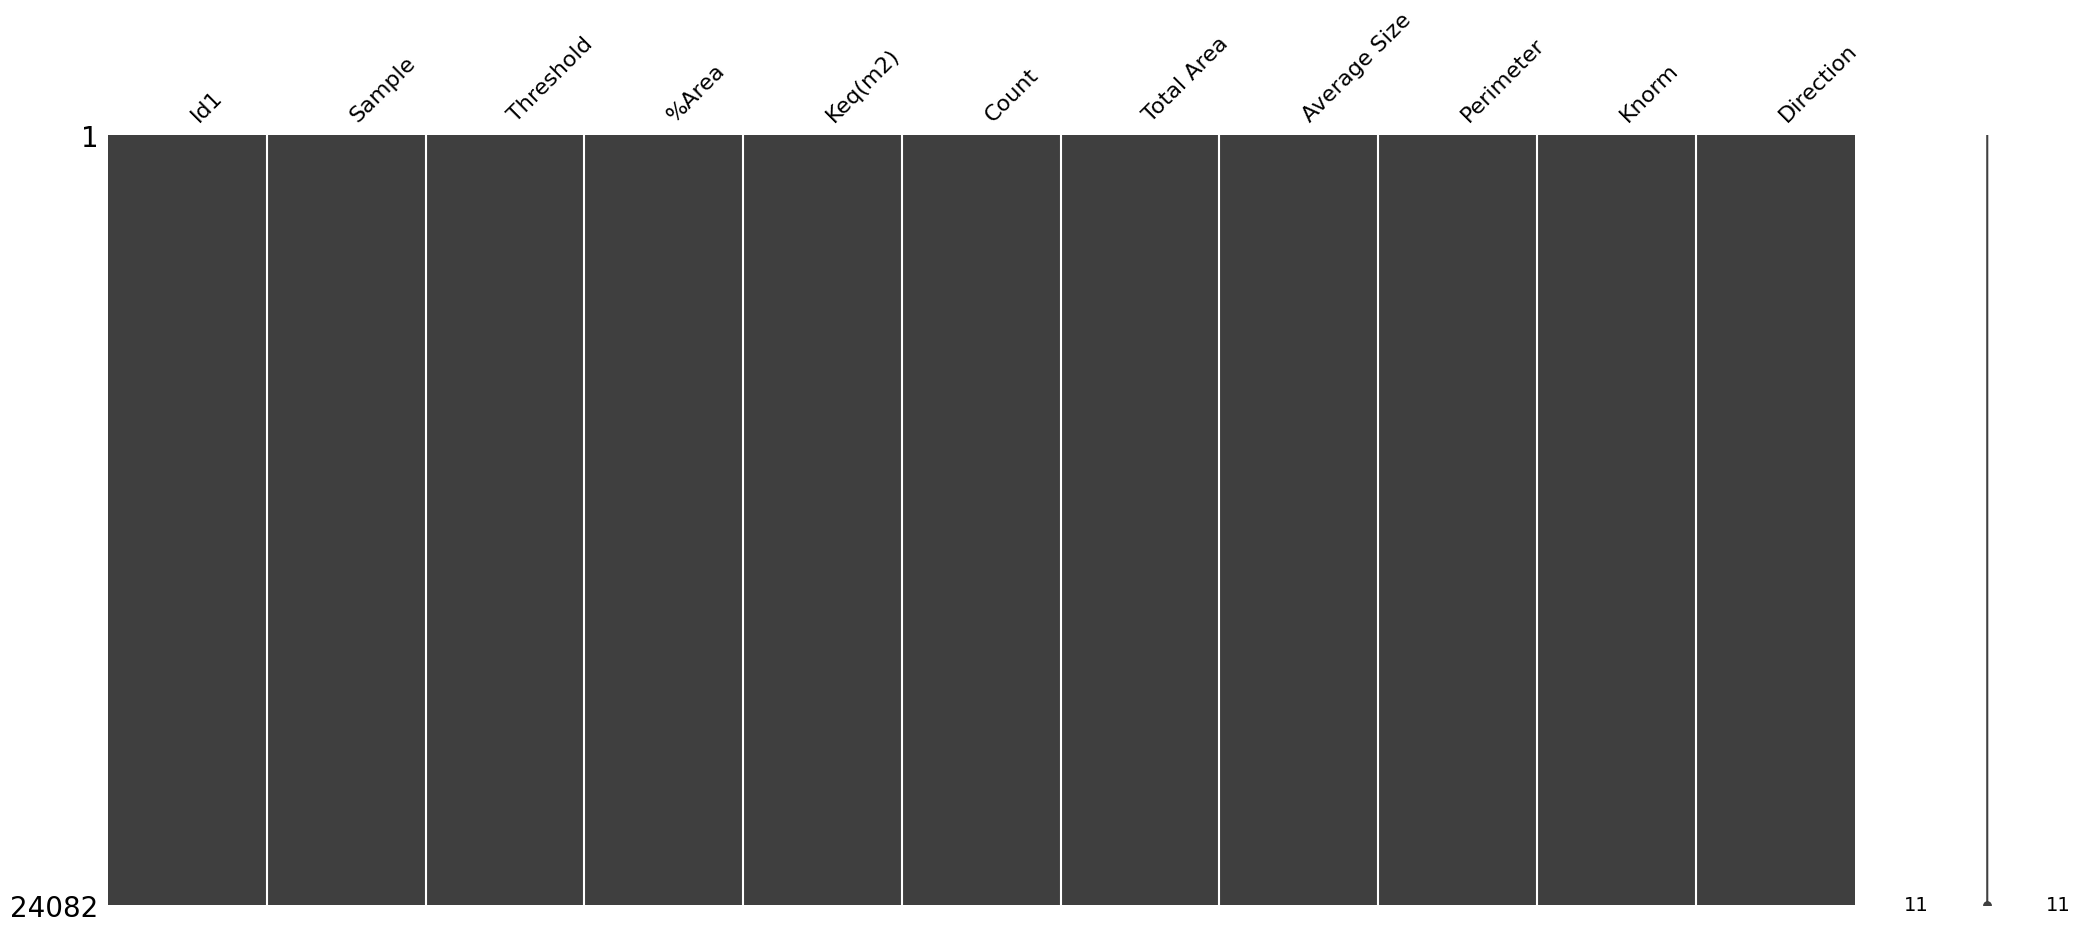

In [32]:
# Copy and clean data
nomissing_dataset = pre_process.clean_data(nolabel_dataset)

# Missings matrix plot after cleaning
ms.matrix(nomissing_dataset)

Além de valores nulos, o dataset original apresenta valores que não condizem com o padrão de resposta esperado, como por exemplo dados de permeabilidade negativa. O menor valor aceitável para Knorm é 1, já que este representa a incremento da permeabilidade pela presença de cavidades. Neste caso 1 nos diz que não houve melhora do escoamento, mas não se espera uma piora no escoamento pela presença de vazios no meio poroso, Knorm<1. 

Além disso, para o modelo não se faz necessário analisar lâminas onde a soma das áreas vazias sejam muito maiores que a matriz porosa. Nesse caso, essa áreas deixam de ser possíveis de ser encontradas em amostras íntegras de rocha.

In [33]:
# Ignore rows with non expected values
# Ignore rows with Knorm < 1
cleaned_dataset = pre_process.ignore_values(nomissing_dataset, 'Knorm', 'bigger', 1)
# Ignore rows with %Area > 80
cleaned_dataset = pre_process.ignore_values(cleaned_dataset, '%Area', 'less', 80)

In [34]:
# Info about missings and clean data
print("Dataframe rows before clean: "+str(nolabel_dataset.shape[0]))
print("Missings: "+str(nolabel_dataset.shape[0]-nomissing_dataset.shape[0]))
print("Values out of range: " + str(nomissing_dataset.shape[0]-cleaned_dataset.shape[0]))

print("\nDataframe after clean: "+str(cleaned_dataset.shape[0]))

Dataframe rows before clean: 26256
Missings: 2174
Values out of range: 14

Dataframe after clean: 24068


No tratamento dos dados foram excluídas 2174 linhas com valores nulos e 14 com dados fora do range de análise.

### 4.2. Feature Selection



Após o processo de limpeza, vamos observar novamente a distribuição dos atributos do dataset para então selecionar as váriaveis que vão compor o modelo de regressão. 

#### 4.2.1 Visualizações Unimodais

Com o gráfico de densidade para cada atributo do dataset e o boxplot. Veremos que a dispersão dos dados diminuiu um pouco. A coluna Knorm continua apresentando muitos valores acima do máximo do boxplot.

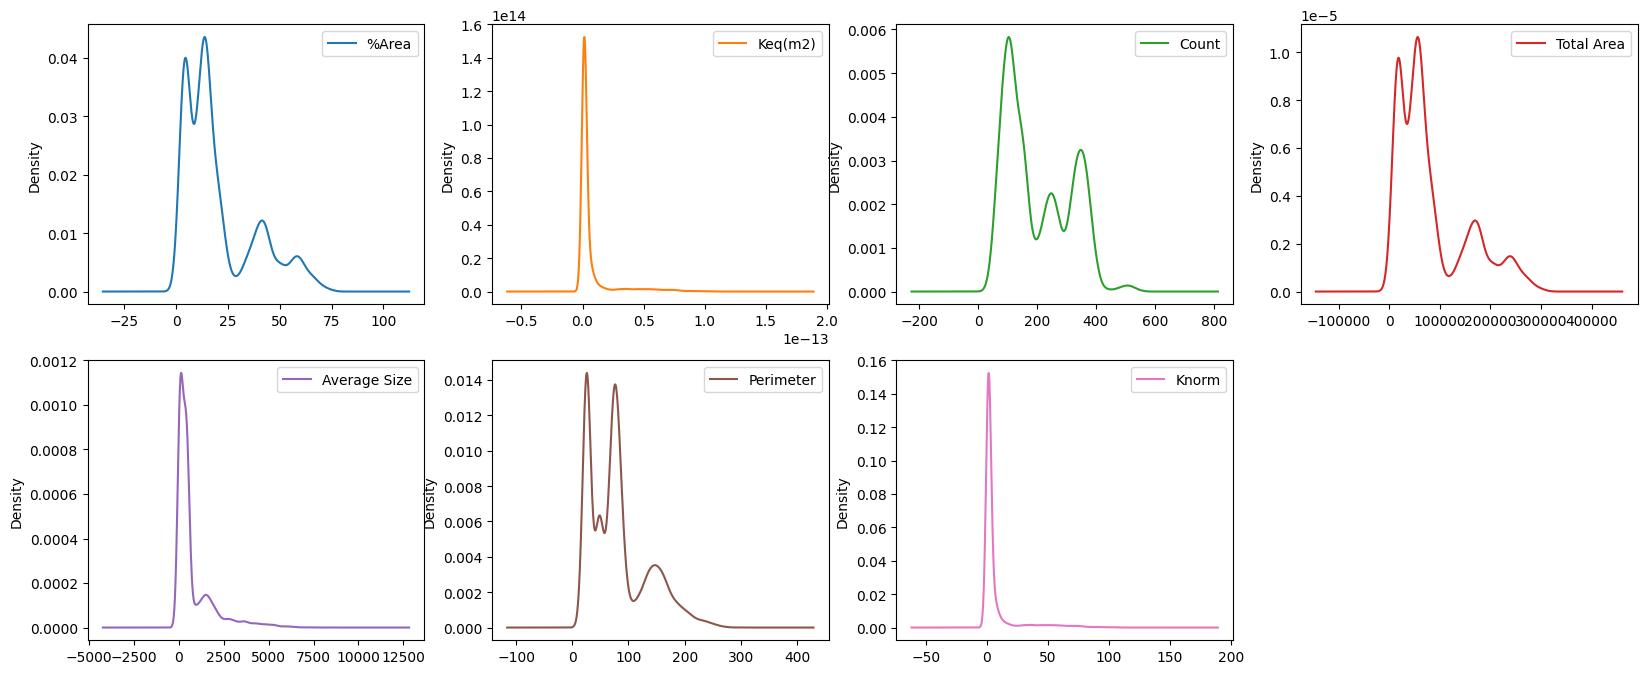

In [35]:
# Density Plot
cleaned_dataset.plot(kind = 'density', subplots = True, layout = (2,4), sharex = False, figsize = (20,8))
plt.show()

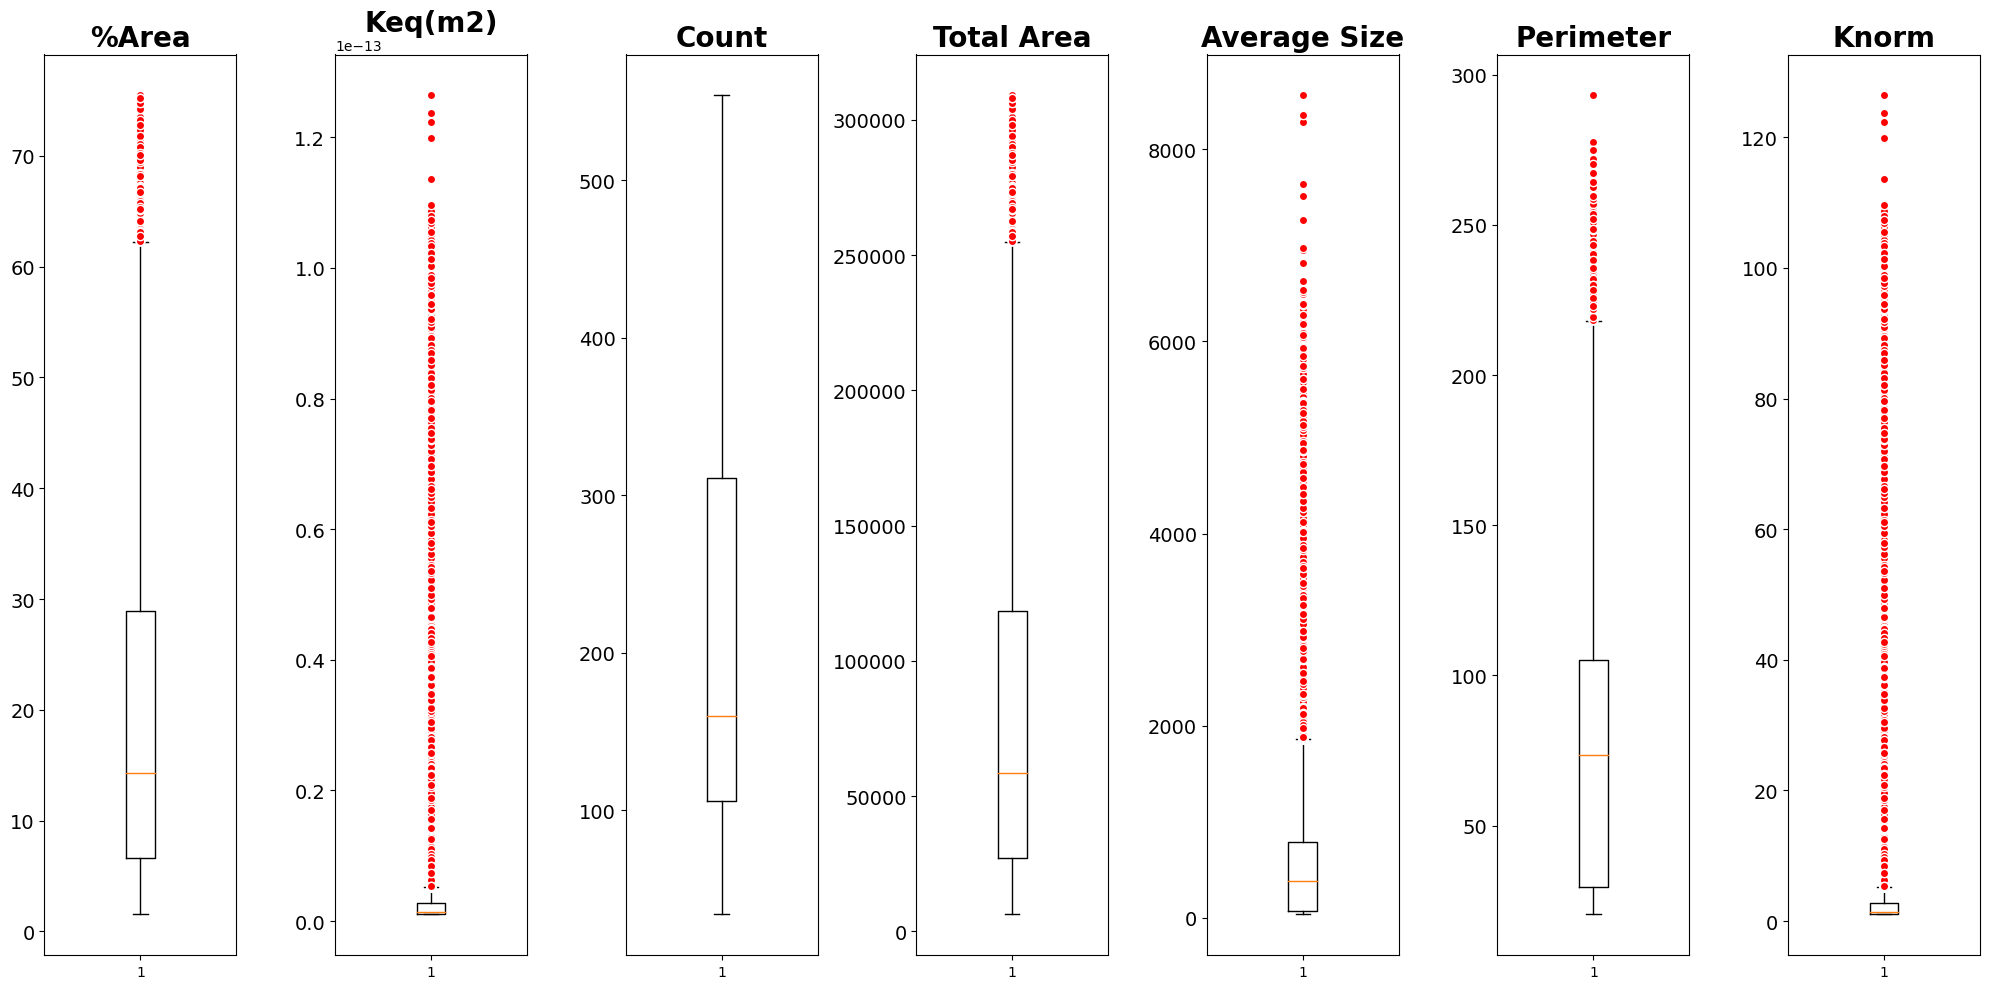

In [36]:
#boxplot 
evaluation.singlerow_boxplot(cleaned_dataset)

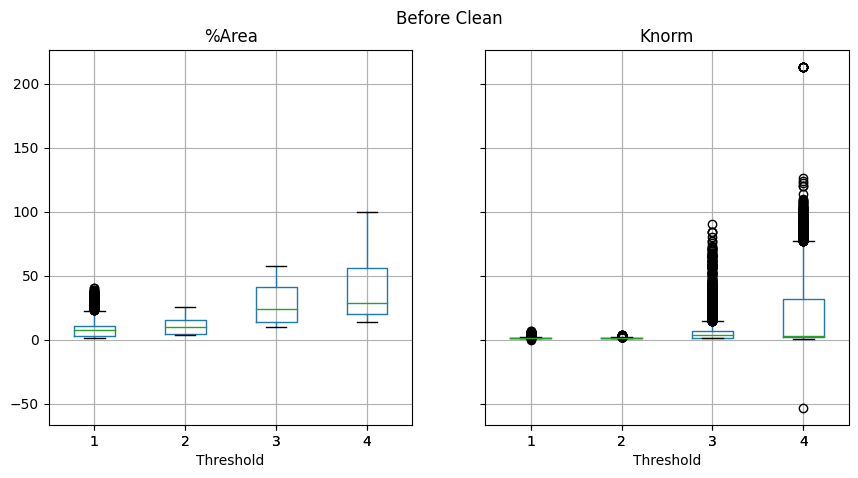

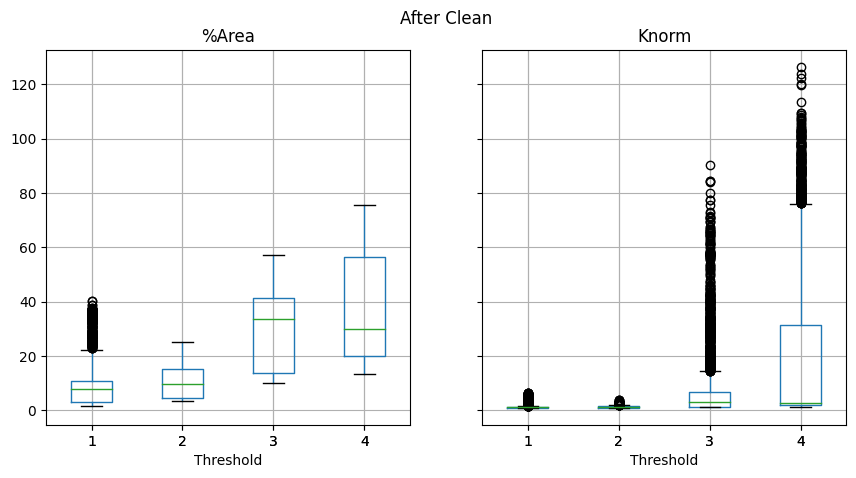

In [37]:
# Boxplots of two variables distributions grouped by the values of a third variable
# Previous dataset 
nolabel_dataset.boxplot(column=['%Area','Knorm'], by='Threshold', layout = (1,2), figsize = (10,5))
plt.suptitle('Before Clean')
# After missings and clear data
cleaned_dataset.boxplot(column=['%Area','Knorm'], by='Threshold', layout = (1,2), figsize = (10,5))
plt.suptitle('After Clean')
plt.show()

#### 4.2.2 Visualizações Multimodais


As correlações entre as variáveis foram novamente acessados através da matriz de correlação e o gráfico de dispersão pareado. O gráfico a seguir indica que após a limpeza a correlação de person teve seus valores afetados. É possivel extrair da matriz a alta correlação positiva que a variável alvo Knorm tem com as demais variáveis exceto Count. A variável Count só apresentou uma correlação negativa próximo do atributo Perimeter. 
No caso de %Area-Total e Keq(m2)-Knorm a matriz a correlação é igual a 1 pois elas indicam o mesmo atributo extraído da imagem. Selecionaremos apenas uma entre estas duas informações para a regressão.

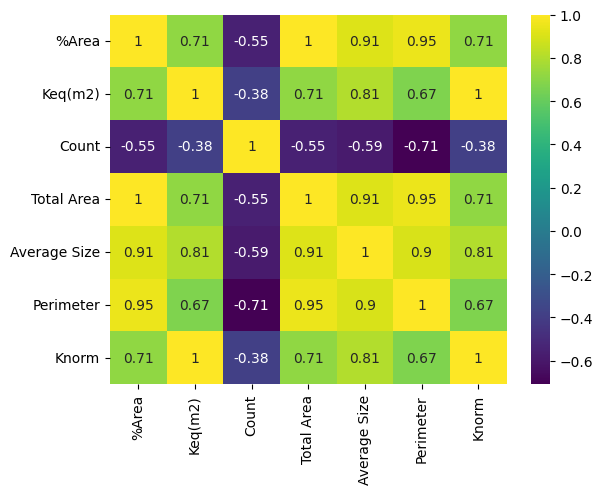

In [38]:
# Matriz de Correlação com Matplotlib Seaborn
sns.heatmap(cleaned_dataset.corr(), annot=True, cmap='viridis');

O mapa de cor no gráfico de correlação pareada separa os dados referentes as 2 amostras utilizadas para cada par de atributos dos dataset. É possivel observar que uma função polinomial se adequa entre os pares Average Size-%Area e Average Size-Perimeter. Também há conjunto de dados entre as amostras bem diferentes para alguns atributos.

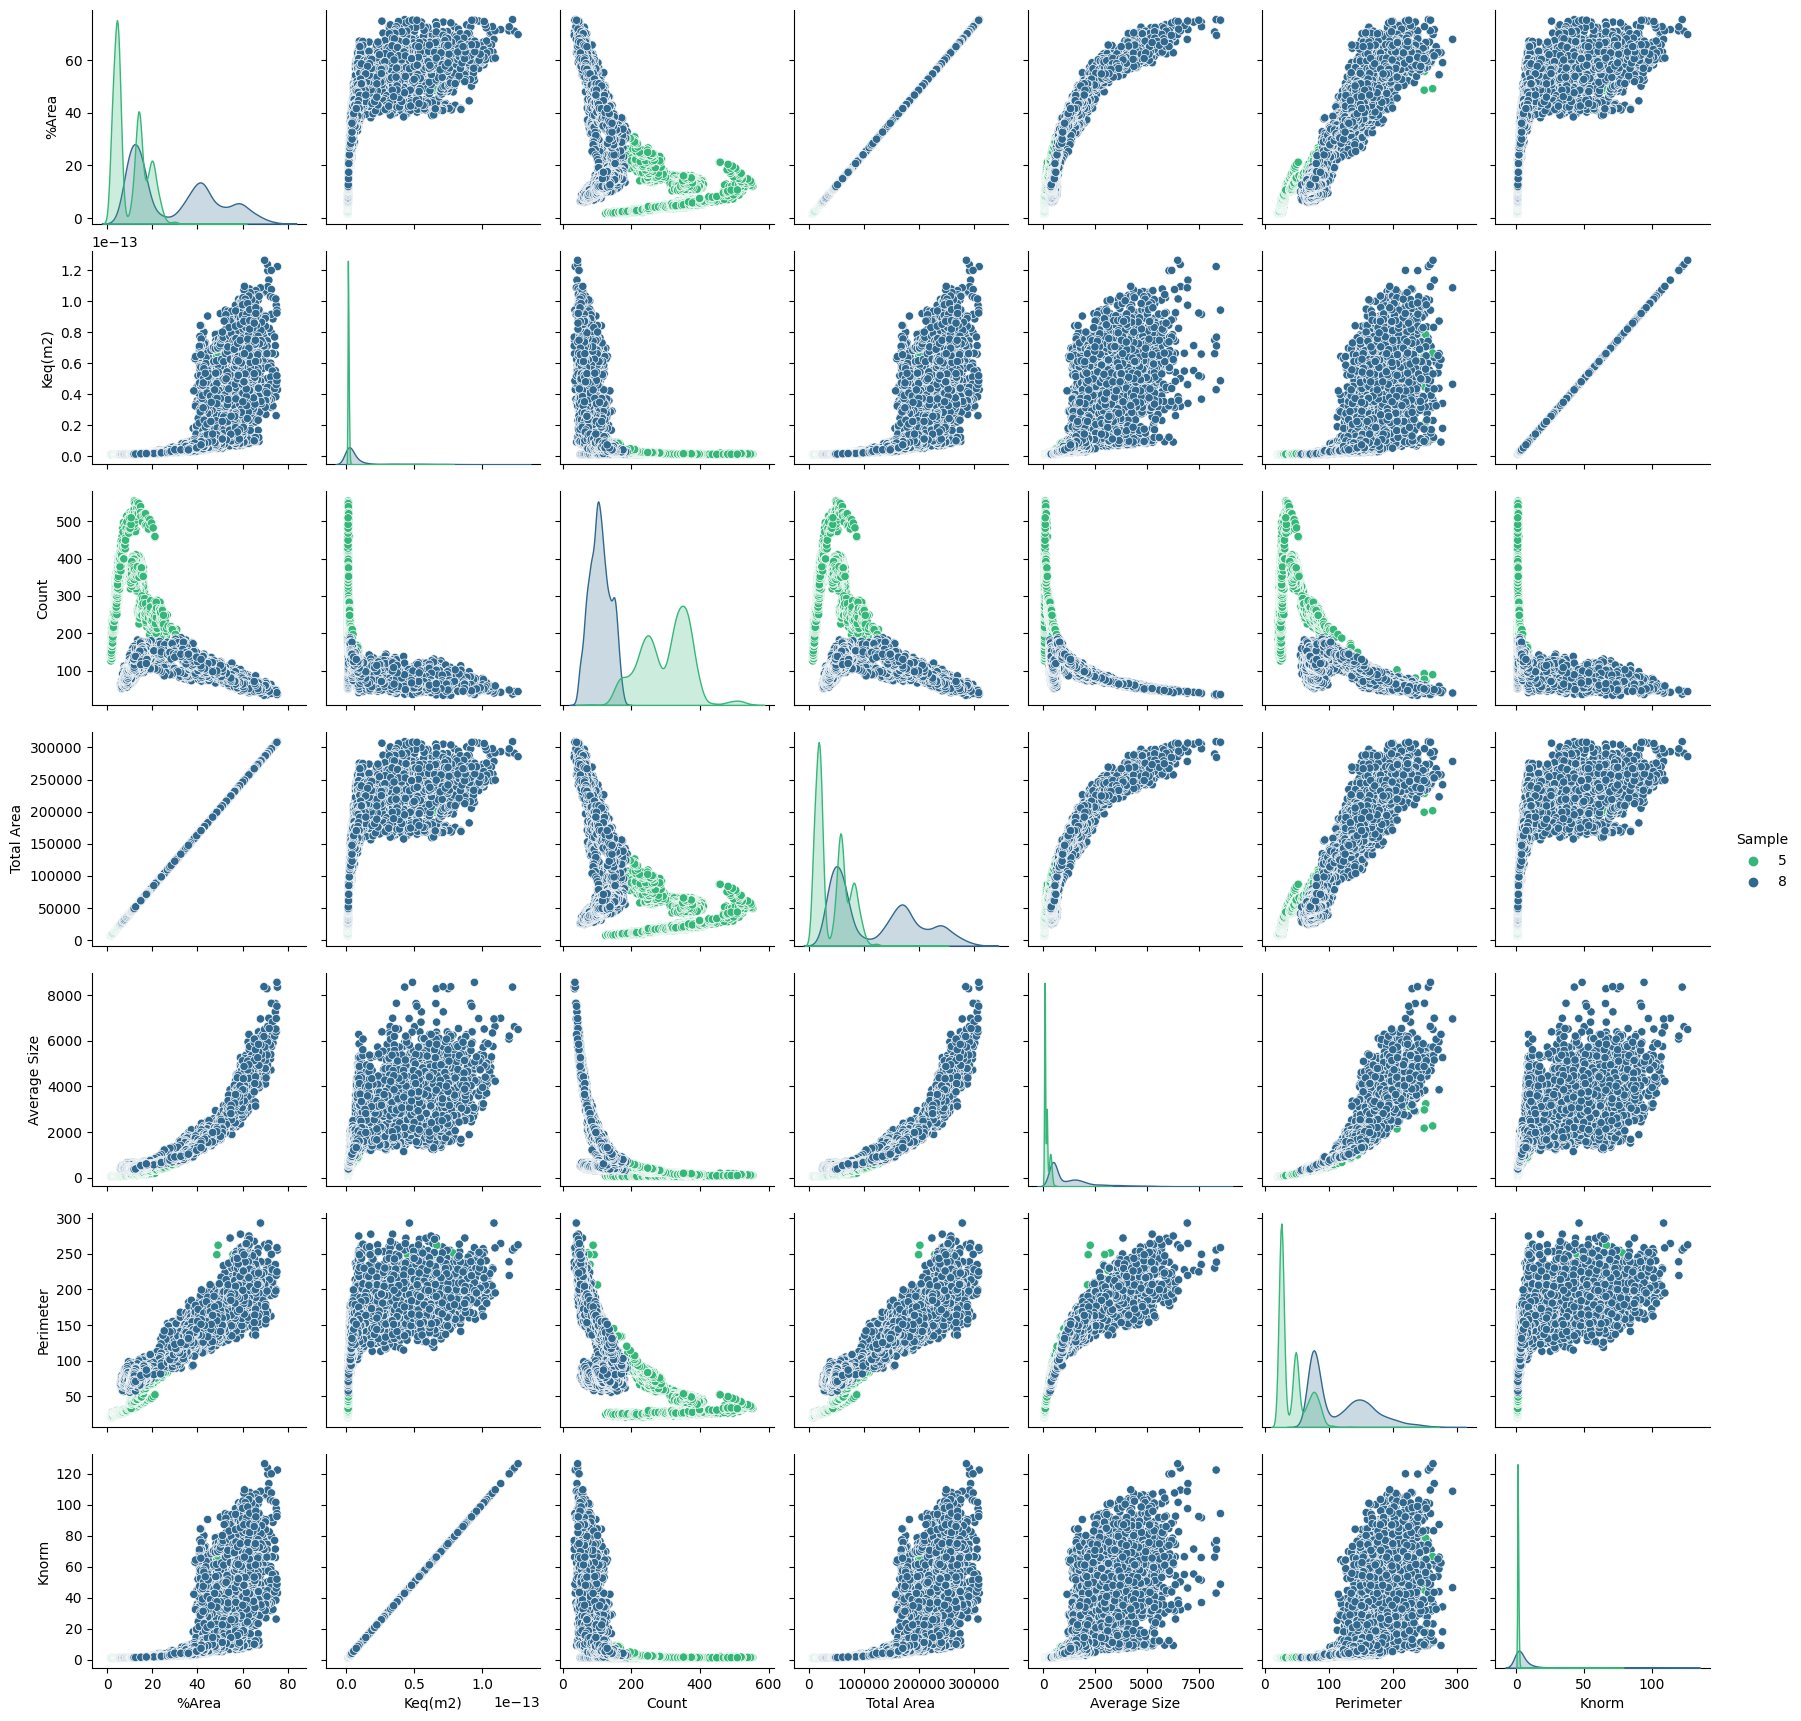

In [39]:
# Seaborn plot for pairwise relationship coloured by Sample
sns.pairplot(cleaned_dataset, hue = "Sample", palette = "viridis_r", height = 2.5)

No gráfico que agrupa os dados em relação ao atributo Direction, observa-se uma distribuição igualitária dos dados dentro desta categoria.

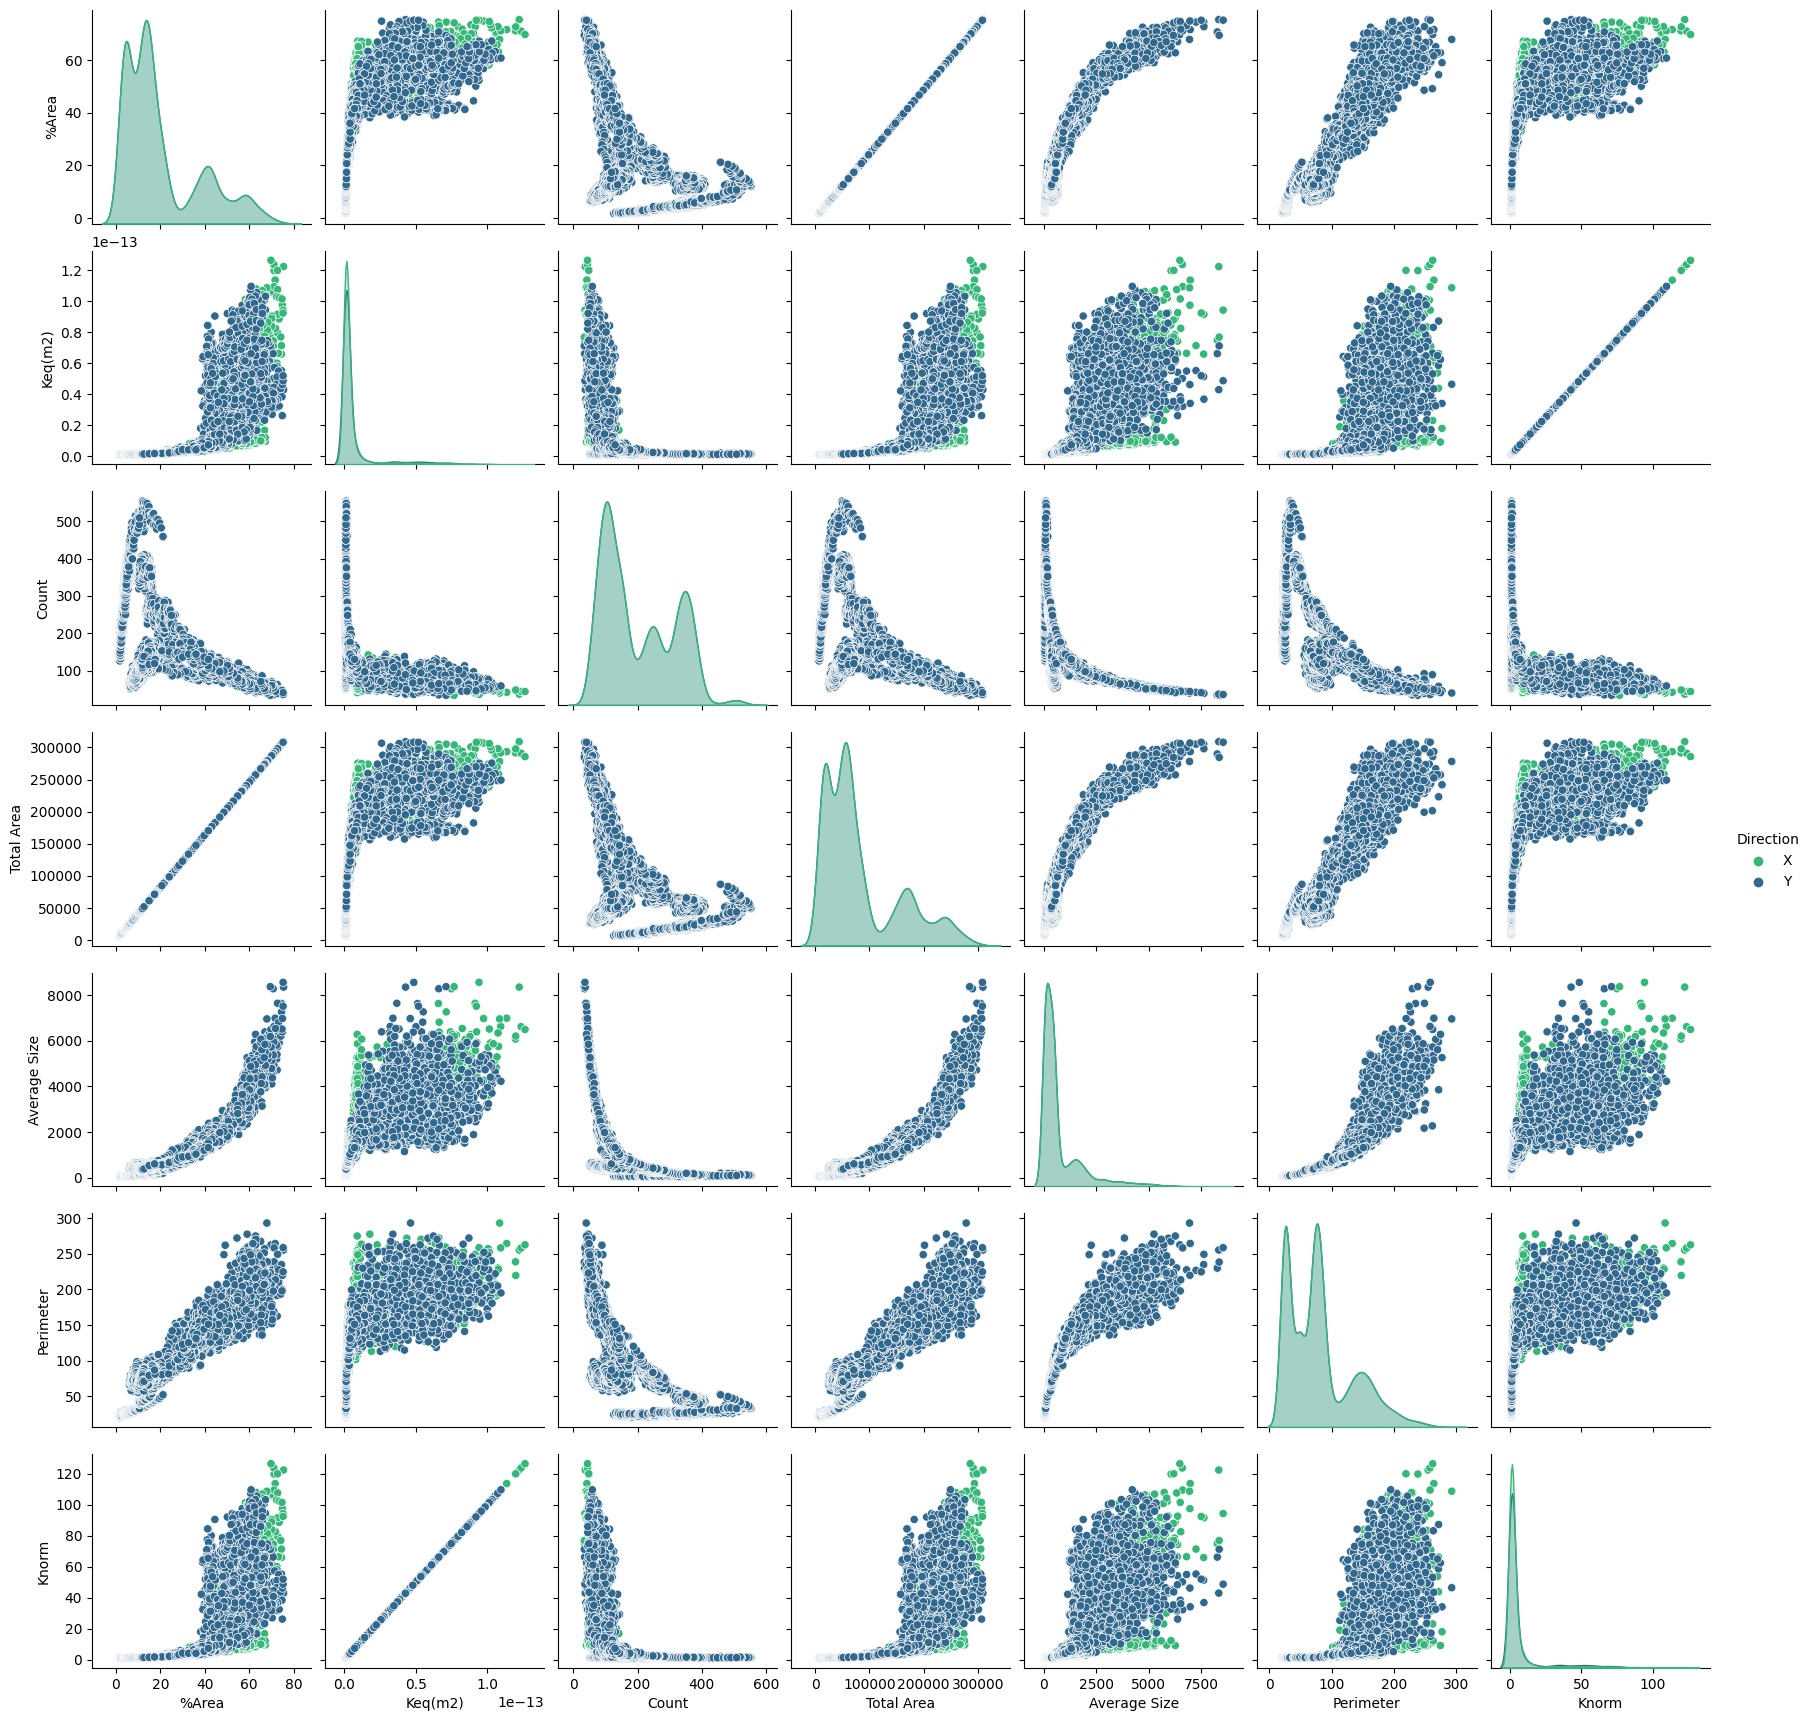

In [40]:
# Seaborn plot for pairwise relationship coloured by Direction
sns.pairplot(cleaned_dataset, hue = "Direction", palette = "viridis_r", height = 2.5)

A seguir apresentamos o mesmo gráfico de correlação pareada agora setorizado pela variável Threshold. Nos gráficos de densidade nota-se distribuições bimodais dentro de cada Threshold para os atributos %Area, Total Area e Perimeter.

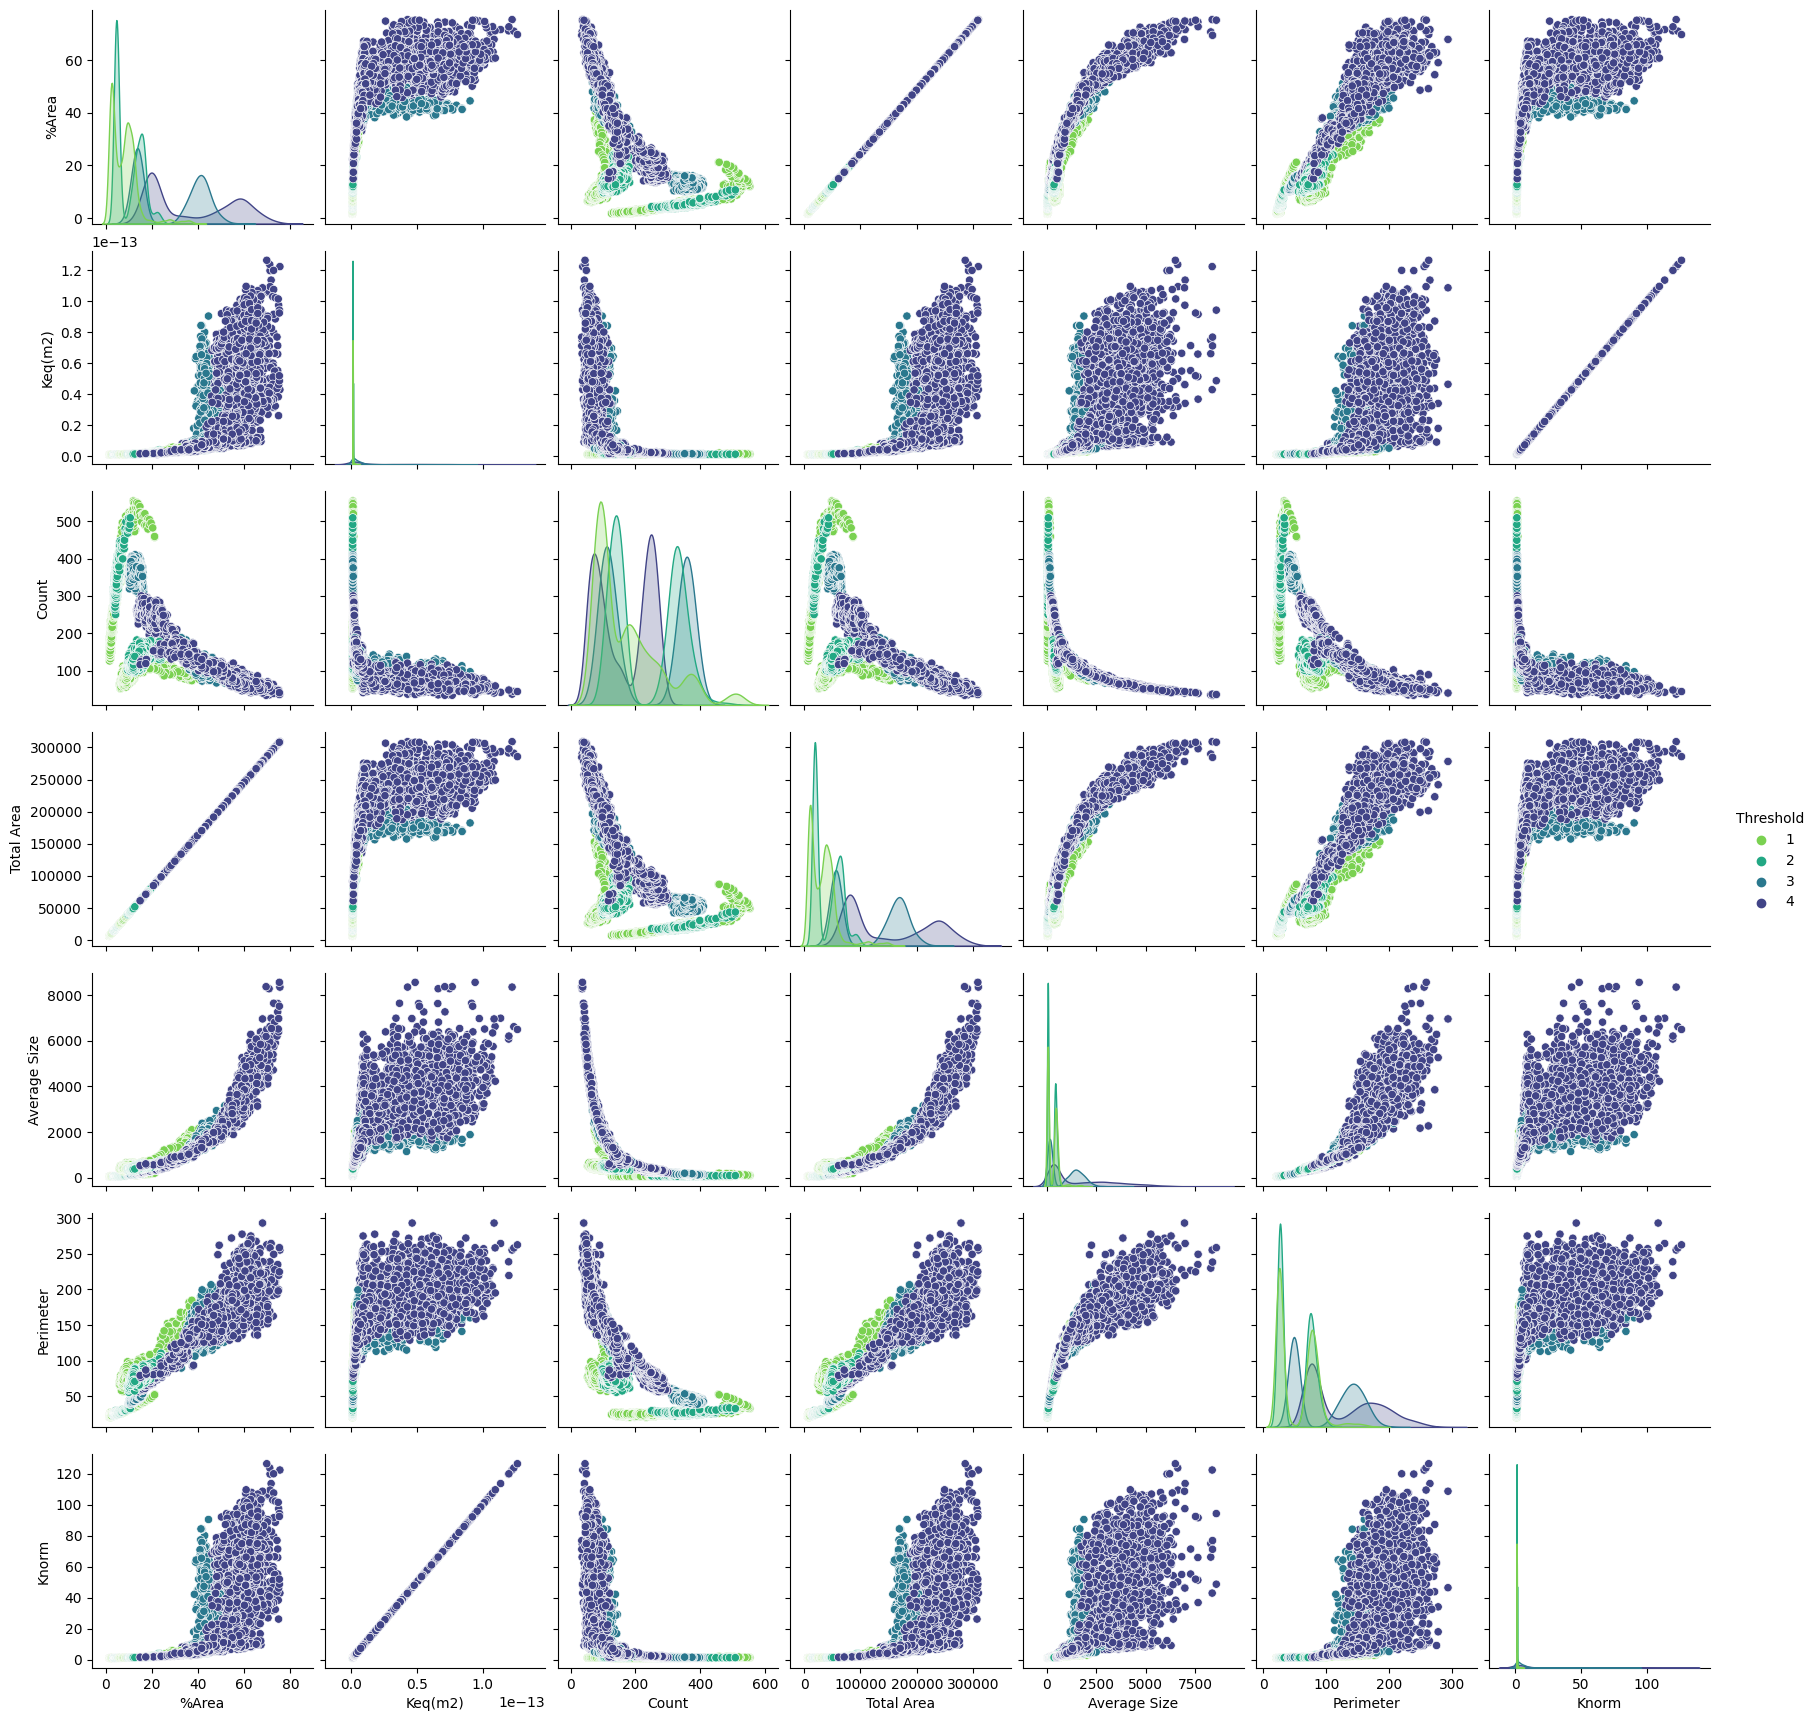

In [41]:
# Seaborn plot for pairwise relationship coloured by Threshold variable
sns.pairplot(cleaned_dataset, hue = "Threshold", palette = "viridis_r", height = 2.5)

#### 4.2.3 Selection

Do dataset original algumas colunas serão selecionadas para a criação do modelo. Os atributos desprezados são as relacionadas ao índice (Image_file,  Id2, Slice e Direction); constantes utilizadas na simulação (K(m2) e Delta P(Pa)) e variáveis altamente correlacionada com outros atributos (Total Area e Keq(m2)).

In [42]:
# Selected columns
headers_values = ['Id1', 'Sample', 'Threshold', '%Area', 'Count', 'Average Size', 'Perimeter', 'Knorm']

# Load the selected columns of the dataframe
select_dataset = cleaned_dataset[headers_values]

# Show few lines of the dataframe
select_dataset.head()

Id1 Sample Threshold     %Area  Count  Average Size  Perimeter  \
0  am5_c1_s150      5         1  11.85522    479     101.37578   36.33522   
1  am5_c1_s151      5         1  12.04248    496      99.44758   35.89300   
2  am5_c1_s152      5         1  10.85474    496      89.63911   33.38860   
3  am5_c1_s153      5         1   9.97021    468      87.26068   32.84939   
4  am5_c1_s154      5         1   8.76489    478      75.10669   29.62648   

     Knorm  
0  1.31343  
1  1.31313  
2  1.25646  
3  1.23396  
4  1.19440

In [43]:
# Get the column names
col_original = list(dataset.columns)
col_selection = list(select_dataset.columns)

# Info about changes
print("Original headers:\n"+str(col_original))
print("\nSelected features:\n"+str(col_selection))

Original headers:
['Image_file', 'Id1', 'Id2', 'Sample', 'Threshold', 'Slice', '%Area', 'K(m2)', 'Keq(m2)', 'Delta P(Pa)', 'Count', 'Total Area', 'Average Size', 'Perimeter', 'Knorm', 'Direction']

Selected features:
['Id1', 'Sample', 'Threshold', '%Area', 'Count', 'Average Size', 'Perimeter', 'Knorm']


### 4.3. Separação em conjunto de treino e conjunto de teste

Usaremos 80% do conjunto de dados para modelagem e guardaremos 20% para testar o modelo. Primeiramente, iremos sinalizar quais são as colunas de atributos e qual é a coluna com a variável alvo (Knorm). A coluna Id1 representa o índice e não será utilizada como variável independente X. Para garantir a reprodutibilidade dos resultados, especificou-se uma semente na função. Finalmente, faremos a separação dos dados e 4 conjuntos: conjunto de treino com os atributos, conjunto de treino com a resposta esperada, conjunto de teste com os atributos e conjunto de teste com a resposta esperada.


In [60]:
# Split data in train and test set
X_train, X_test, Y_train, Y_test = pre_process.pre_processing(select_dataset[col_selection[3:]], percentual_test)

### 4.4 Normalização e Padronização

Padronizando os dados

In [62]:
#Standard Scaler
X_train_meansc, X_test_meansc = pre_process.standardization(X_train, X_test)

Normalizando os dados

In [63]:
#Min Max Scaler
X_train_rangesc, X_test_rangesc = pre_process.normalization(X_train, X_test)

## 5. Modelo

Avaliação de vários modelos em partições da validação cruzada

In [64]:
# Create folds to cross validation
n_cv = 5 # number of folds in cross validation
kfold = KFold(n_splits=n_cv, shuffle=True, random_state=7) # partitioning

In [65]:
# Models list to train
models = []

# Preparing holdout
models.append(('LR', LinearRegression()))
models.append(('Extra', ExtraTreesRegressor()))
models.append(('Decision', DecisionTreeRegressor()))
models.append(('XGB', XGBRegressor()))
models.append(('Grad', GradientBoostingRegressor()))
models.append(('RF', RandomForestRegressor()))
models.append(('LGBM', LGBMRegressor()))
models.append(('SVM', SVR()))
models.append(('SGD', SGDRegressor()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('KNN', KNeighborsRegressor()))

In [73]:
# Evaluate a bunch of models using cross validation
(model_names_mean, results_mean) = select_model.train_models(models, X_train_meansc, Y_train, kfold)

Model:	 MAE_mean	 (MAE_std)

LR: 3.345423 (0.091217)
Extra: 3.020438 (0.061889)
Decision: 3.202459 (0.068002)
XGB: 2.808969 (0.060511)
Grad: 2.637311 (0.072543)
RF: 2.747832 (0.068996)
LGBM: 2.593645 (0.094429)
SVM: 2.505640 (0.078600)
SGD: 3.471911 (0.094377)
Ridge: 3.345955 (0.091170)
Lasso: 4.416045 (0.078564)
KNN: 2.639898 (0.074396)


In [74]:
# Evaluate a bunch of models using cross validation
(model_names_range, results_range) = select_model.train_models(models, X_train_rangesc, Y_train, kfold)

Model:	 MAE_mean	 (MAE_std)

LR: 3.345423 (0.091217)
Extra: 3.018280 (0.061796)
Decision: 3.224462 (0.047936)
XGB: 2.809375 (0.060437)
Grad: 2.637437 (0.072489)
RF: 2.752439 (0.079114)
LGBM: 2.580471 (0.097127)
SVM: 2.495172 (0.087213)
SGD: 3.503680 (0.102542)
Ridge: 3.377865 (0.089606)
Lasso: 5.484402 (0.099377)
KNN: 2.650407 (0.075886)


Boxplot de comparação dos modelos

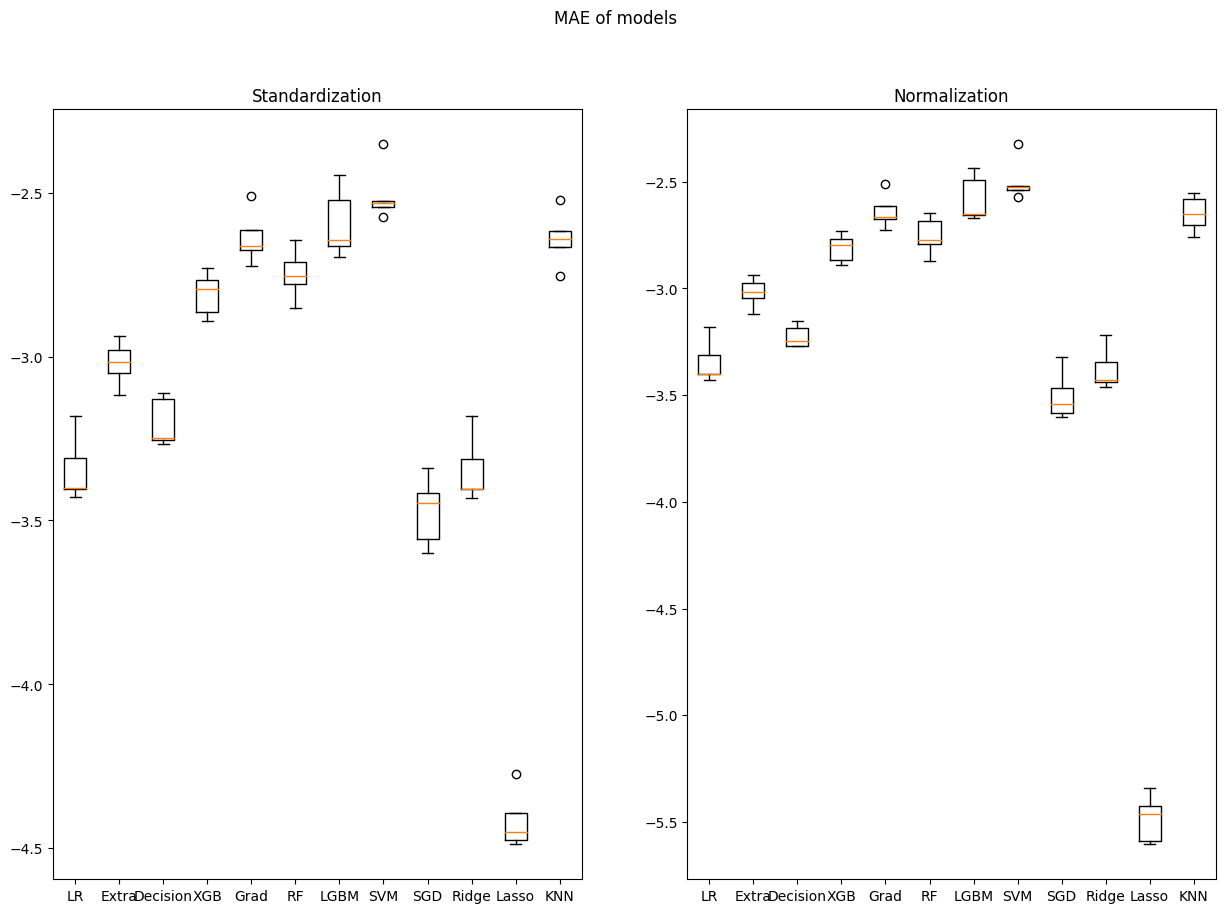

In [91]:
# Model comparison
fig = plt.figure(figsize=(15,10))
fig.suptitle('MAE of models') 
ax1 = fig.add_subplot(121) 
# Boxplot
plt.boxplot(results_mean) 
ax1.set_xticklabels(model_names_mean) 
ax1.title.set_text("Standardization")

ax2 = fig.add_subplot(122) 
# Boxplot
plt.boxplot(results_range) 
ax2.set_xticklabels(model_names_range) 
ax2.title.set_text("Normalization")

plt.show()

### 5.2 Seleção do Modelo

Utilizando o modelo XGBRegressor e analisando a importancia de cada variável no modelo

In [92]:
# Selecting training model
xgb_model = XGBRegressor()
model = select_model.generic_train(xgb_model, X_train_meansc, Y_train)

# Model score
xgb_prediction = evaluation.eval_accuracy(xgb_model, X_test_meansc, Y_test)

MAE:3.11	 MSE:93.79	 RMSE:9.68



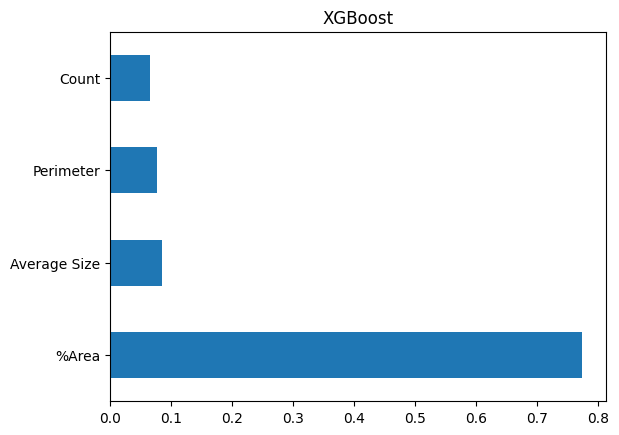

In [93]:
feat_importances = pd.Series(xgb_model.feature_importances_, index=col_selection[3:-1])
feat_importances.nlargest(20).plot(kind='barh')
plt.title('XGBoost')
plt.show()

Comparando a predição com o valor original

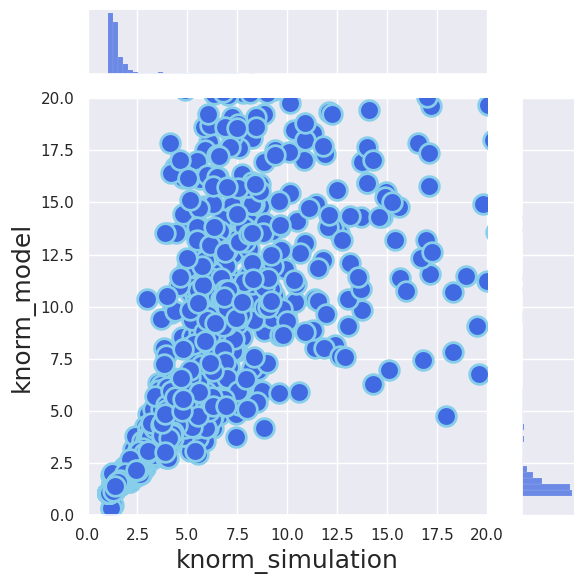

In [95]:
# Draw a plot of two variables
sns.set(font_scale=1.0)
df = pd.DataFrame({'simulation':Y_test,'prediction': xgb_prediction})
sns_plot = sns.jointplot(data=df,x='simulation',y='prediction', kind='scatter', s=200, color="royalblue", edgecolor="skyblue", linewidth=2)
sns_plot.set_axis_labels('knorm_simulation', 'knorm_model', fontsize=18)

# Set axis limit
sns_plot.ax_marg_x.set_xlim(0, 20)
sns_plot.ax_marg_y.set_ylim(0, 20)

# labels appear outside of plot area, so auto-adjust
sns_plot.figure.tight_layout() 

Utilizando o modelo Suport Vector Machine e analisando a importancia de cada variável no modelo

In [96]:
# Selecting training model
svm_model = select_model.train_SVM(X_train_meansc, Y_train)

# Model score
svm_prediction = evaluation.eval_accuracy(svm_model, X_test_meansc, Y_test)

MAE:2.98	 MSE:92.29	 RMSE:9.61



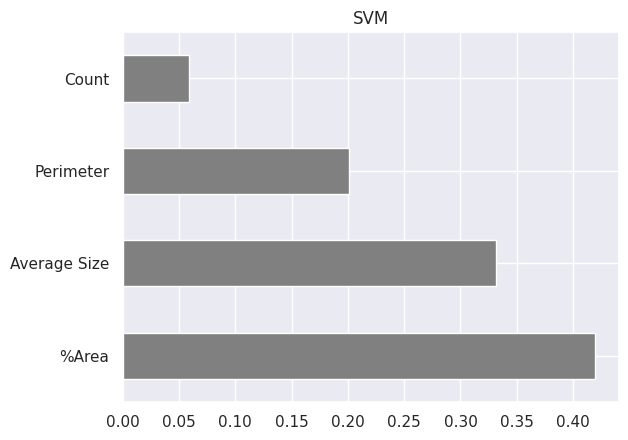

In [97]:
# perform permutation importance
results = permutation_importance(svm_model, X_train_meansc, Y_train)
# get importance
importance = results.importances_mean
feat_importances = pd.Series(importance, index=col_selection[3:-1])
feat_importances.nlargest(20).plot(kind='barh',color='gray')
plt.title('SVM')
plt.show()

Comparando a predição com o valor original

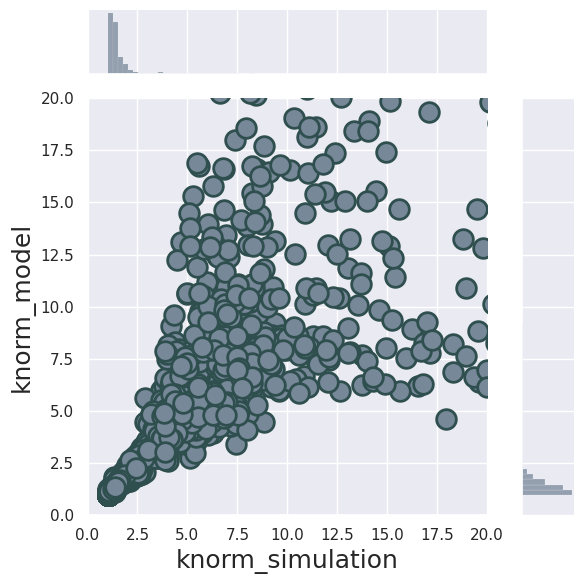

In [103]:
# Draw a plot of two variables
sns.set(font_scale=1.0)
df = pd.DataFrame({'simulation':Y_test,'prediction': svm_prediction})
sns_plot = sns.jointplot(data=df,x='simulation',y='prediction', kind='scatter', s=200, color="lightslategrey", edgecolor="darkslategrey", linewidth=2)
sns_plot.set_axis_labels('knorm_simulation', 'knorm_model', fontsize=18)

# Set axis limit
sns_plot.ax_marg_x.set_xlim(0, 20)
sns_plot.ax_marg_y.set_ylim(0, 20)

# labels appear outside of plot area, so auto-adjust
sns_plot.figure.tight_layout() 

**Conclusão do modelo**

Os dois modelos apresentaram baixa acurácia para o conjunto de teste. As váriaveis independentes não foram suficientes para uma predição satisfatória do modelo de regressão. É recomendado a extração de mais atributos das imagens pertencentes a base de dados.

**Em progresso**

Com a biblioteca de análise de imagens scikit-image é possível medir propriedades de objetos em uma figura rotulada. Utilizamos a função skimage.measure.regionprops_table() para extrair as propiedades de cada imagem e salvar em um arquivo compatível com a biblioteca pandas. Uma nova base de dados para a imagem será criada com a média ponderada pela área do objeto de cada atributo extraído.

O script de extração de dados encontra-se disponível em: https://raw.githubusercontent.com/mfdali/PermeabilityCircularVugs/main/image_properties.py